<a href="https://colab.research.google.com/github/mat669/Macroeconomics/blob/main/Adv_Macro_project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Advanced Macroeconomics project**
#### *By Mathias Cardarello Fierro & Matteo Ciarrocchi*
Version 2.0 (16/6/21)

**testo in grassetto**# **Setup**

In [ ]:
# Install statsmodels
!pip3 install git+https://github.com/statsmodels/statsmodels.git

  Cloning https://github.com/statsmodels/statsmodels.git to /tmp/pip-req-build-jw4vc5ax
  Running command git clone -q https://github.com/statsmodels/statsmodels.git /tmp/pip-req-build-jw4vc5ax
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.13.0.dev0+402.g081fc6e85-cp37-cp37m-linux_x86_64.whl size=17627556 sha256=619777d9f375ae0ef5b82519b609edb9eca0443b8936d0c0841bbb02b2cb0c0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-o3ji5n7x/wheels/7b/bd/6d/3192a61f34609bda0eea70342907984dba2ad17c3abb502ce7
Successfully built statsmodels
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# Install pmdarima
!pip install pmdarima

     |████████████████████████████████| 1.5MB 7.5MB/s 


In [ ]:
# Install arch
!pip3 install arch

     |████████████████████████████████| 808kB 7.6MB/s 


In [ ]:
# Install armagarch
!pip install armagarch

In [ ]:
# Import libraries

%matplotlib inline
import matplotlib.pyplot as pyplot
from pandas import DataFrame

import seaborn
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns, math, os, warnings 

warnings.filterwarnings('ignore')

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.tsa.ar_model as  AR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

from arch import arch_model
from arch.univariate import ARX, ARCH, GARCH

from patsy import dmatrices

from sklearn.metrics import auc
import xgboost as xgb
import sklearn as sklearn

from scipy.stats import shapiro
from scipy.stats import probplot

def ts_plot(residuals, stan_residuals, lags=15):
    residuals.plot(title='GARCH Residuals', figsize=(8, 5))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(stan_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stan_residuals, lags=lags)
    pacf = plot_pacf(stan_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=20)
    acf.set_figheight(5)
    acf.set_figwidth(10)
    pacf.set_figheight(5)
    pacf.set_figwidth(10)
    plt.show()

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

In [ ]:
# Import data (directly from the Github repository)
df_monthly = pd.read_csv('https://raw.githubusercontent.com/mathicard/Adv-Macroeconomics-DSE/main/monthly.csv')
df_quarterly = pd.read_csv('https://raw.githubusercontent.com/mathicard/Adv-Macroeconomics-DSE/main/quarterly.csv')
df_yearly = pd.read_csv('https://raw.githubusercontent.com/mathicard/Adv-Macroeconomics-DSE/main/yearly.csv')

In [ ]:
# Create a datetime index
df_monthly.index = pd.to_datetime(df_monthly["date"])
df_quarterly.index = pd.to_datetime(df_quarterly["date"])
df_yearly.index = pd.to_datetime(df_yearly["date"])

# **Data description**

In [ ]:
# Let's take a look at our datasets
df_monthly.head(5)

,date,DY,RER,GER,INF,CPI,MP,UM,OP,BITCOIN,IR1TY,IR1US,RIR1TY,RIR1US,RIR1
date,,,,,,,,,,,,,,,
1970-01-01,1970-01-01,NaN,NaN,NaN,0.064880,0.000064,NaN,NaN,3.35,NaN,NaN,NaN,NaN,NaN,NaN
1970-02-01,1970-02-01,NaN,NaN,NaN,0.067511,0.000064,NaN,NaN,3.35,NaN,NaN,NaN,NaN,NaN,NaN
1970-03-01,1970-03-01,NaN,NaN,NaN,0.068917,0.000065,NaN,NaN,3.35,NaN,NaN,NaN,NaN,NaN,NaN
1970-04-01,1970-04-01,NaN,NaN,NaN,0.068022,0.000065,NaN,NaN,3.35,NaN,NaN,NaN,NaN,NaN,NaN
1970-05-01,1970-05-01,NaN,NaN,NaN,0.066110,0.000065,NaN,NaN,3.35,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_monthly.tail(5)

,date,DY,RER,GER,INF,CPI,MP,UM,OP,BITCOIN,IR1TY,IR1US,RIR1TY,RIR1US,RIR1
date,,,,,,,,,,,,,,,
2021-01-01,2021-01-01,0.252488,13.220642,0.416615,0.149737,196.979872,20.25315,12.2,52.00,33114.35938,16.98,0.09,16.830263,0.076002,16.754261
2021-02-01,2021-02-01,0.293505,12.690974,0.330412,0.156109,198.768156,20.51404,NaN,59.04,45137.76953,17.08,0.08,16.923891,0.063238,16.860653
2021-03-01,2021-03-01,NaN,13.738291,0.367818,0.161902,200.905655,21.61576,NaN,62.33,58918.83203,17.88,0.07,17.718098,0.043802,17.674295
2021-04-01,2021-04-01,NaN,14.811144,0.344902,0.171402,204.278834,NaN,NaN,61.72,57750.17578,19.06,0.07,18.888598,0.028350,18.860249
2021-05-01,2021-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.17,35697.60547,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_quarterly.head(5)

,date,V1,V2,GDP,RIR1,BITCOIN,OP,DY,IR1
date,,,,,,,,,
1998-01-01,01/01/98,3437.103774,890.478518,180224.3966,NaN,NaN,15.930000,-0.715460,81.623333
1998-01-04,01/04/98,3236.077834,782.929468,178788.8318,NaN,NaN,14.653333,-0.754958,74.163333
1998-01-07,01/07/98,2825.819214,715.199086,176273.1390,NaN,NaN,14.130000,-0.743309,74.000000
1998-01-10,01/10/98,2918.591388,659.115382,175817.1413,NaN,NaN,12.840000,-0.810925,85.373333
1999-01-01,01/01/99,2840.965842,603.801214,172853.1804,NaN,NaN,13.046667,-0.856646,82.490000


In [ ]:
df_quarterly.tail(5)

,date,V1,V2,GDP,RIR1,BITCOIN,OP,DY,IR1
date,,,,,,,,,
2020-01-04,01/04/20,343.757000,123.069903,403722.2919,8.360479,9137.993164,27.806667,0.055678,8.533333
2020-01-07,01/07/20,367.191785,139.264016,468065.1967,9.327947,10787.618160,40.893333,0.229828,9.526667
2020-01-10,01/10/20,383.697773,142.765811,475901.2813,14.290678,29001.720700,42.453333,0.249471,14.503333
2021-01-01,01/01/21,NaN,NaN,NaN,NaN,NaN,57.790000,0.272996,17.313333
2021-01-04,01/04/21,NaN,NaN,NaN,NaN,NaN,63.445000,NaN,19.060000


In [ ]:
df_yearly.head(5)

,date,GAP
date,,
1990-01-01,01/01/90,-169666.21800
1991-01-01,01/01/91,-136059.97030
1992-01-01,01/01/92,-146877.84180
1993-01-01,01/01/93,-151371.07680
1994-01-01,01/01/94,-76810.78979


In [ ]:
df_yearly.tail(5)

,date,GAP
date,,
2016-01-01,01/01/16,282297.84890
2017-01-01,01/01/17,286567.83020
2018-01-01,01/01/18,233662.13440
2019-01-01,01/01/19,118475.24040
2020-01-01,01/01/20,66976.98366


In [ ]:
# Checking for null data
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 617 entries, 1970-01-01 to 2021-05-01
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     617 non-null    object 
 1   DY       496 non-null    float64
 2   RER      268 non-null    float64
 3   GER      256 non-null    float64
 4   INF      616 non-null    float64
 5   CPI      616 non-null    float64
 6   MP       159 non-null    float64
 7   UM       193 non-null    float64
 8   OP       617 non-null    float64
 9   BITCOIN  80 non-null     float64
 10  IR1TY    340 non-null    float64
 11  IR1US    340 non-null    float64
 12  RIR1TY   340 non-null    float64
 13  RIR1US   340 non-null    float64
 14  RIR1     340 non-null    float64
dtypes: float64(14), object(1)
memory usage: 77.1+ KB


In [ ]:
df_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94 entries, 1998-01-01 to 2021-01-04
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     94 non-null     object 
 1   V1       92 non-null     float64
 2   V2       92 non-null     float64
 3   GDP      92 non-null     float64
 4   RIR1     24 non-null     float64
 5   BITCOIN  24 non-null     float64
 6   OP       94 non-null     float64
 7   DY       93 non-null     float64
 8   IR1      94 non-null     float64
dtypes: float64(8), object(1)
memory usage: 7.3+ KB


In [ ]:
df_yearly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 1990-01-01 to 2020-01-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    31 non-null     object 
 1   GAP     31 non-null     float64
dtypes: float64(1), object(1)
memory usage: 744.0+ bytes


In [ ]:
# Checking for object data
df_monthly.describe(include=np.object)

,date
count,617
unique,617
top,1993-11-01
freq,1


In [ ]:
df_quarterly.describe(include=np.object)

,date
count,94
unique,94
top,01/10/00
freq,1


In [ ]:
df_yearly.describe(include=np.object)

,date
count,31
unique,31
top,01/01/92
freq,1


In [ ]:
# Summary statistics
df_monthly.describe()

,DY,RER,GER,INF,CPI,MP,UM,OP,BITCOIN,IR1TY,IR1US,RIR1TY,RIR1US,RIR1
count,496.000000,268.000000,256.000000,616.000000,616.000000,159.000000,193.000000,617.000000,80.000000,340.000000,340.000000,340.000000,340.000000,340.000000
mean,-0.527254,2.497194,0.363092,0.367195,33.361867,18.173655,10.533161,36.214379,7705.195576,36.328794,2.478618,36.002470,2.456421,33.546049
std,0.337042,3.204815,0.532374,0.294559,48.821663,2.940830,1.648402,27.505835,11539.433636,43.278291,2.195093,43.054875,2.189907,41.897260
min,-1.118987,0.033637,-0.156841,0.039860,0.000064,9.993018,8.000000,3.310000,217.464005,4.140000,0.050000,4.074853,0.028350,3.978473
25%,-0.776652,0.743901,0.056241,0.101853,0.002272,16.847260,9.200000,16.871000,564.450485,10.397500,0.180000,10.307958,0.173499,9.686511
50%,-0.667966,1.114682,0.201625,0.261080,0.949325,18.618080,10.200000,27.755000,4521.050049,17.590000,1.820000,17.485609,1.797884,14.827085
75%,-0.282410,2.969903,0.399451,0.627103,59.494023,20.418580,11.700000,50.540000,9268.044678,59.010000,4.940000,58.356196,4.901862,55.747303
max,0.293505,14.811144,2.850589,1.258915,204.278834,23.250390,14.300000,133.930000,58918.832030,430.860000,6.540000,430.525781,6.503407,425.071116


In [ ]:
df_quarterly.describe()

,V1,V2,GDP,RIR1,BITCOIN,OP,DY,IR1
count,92.000000,92.000000,92.000000,24.000000,24.000000,94.000000,93.000000,94.000000
mean,1318.228832,315.056084,291401.972607,12.370376,5641.958379,56.970443,-0.349027,26.266099
std,818.186744,188.144842,95180.547553,4.316350,6424.302935,27.358913,0.353869,29.011585
min,343.757000,123.069903,168979.841400,7.839034,236.059998,12.840000,-0.915153,4.893333
25%,697.568745,177.779597,201147.061500,9.457749,657.436478,32.280833,-0.691343,9.546667
50%,908.811922,189.939214,263605.285400,10.791049,4222.057129,55.868333,-0.384491,14.915000
75%,2006.340635,497.945780,377065.221650,13.404553,7468.666382,75.925000,-0.002835,25.975833
max,3437.103774,890.478518,475901.281300,22.195004,29001.720700,123.963333,0.272996,189.160000


In [ ]:
df_yearly.describe()

,GAP
count,31.000000
mean,-59502.567334
std,175358.708210
min,-273898.984000
25%,-183718.846700
50%,-131345.150000
75%,73822.057555
max,286567.830200


In [ ]:
#Skewness: 
#A negative skewness value indicates an asymmetry in the distribution and the tail is larger towards the left hand side of the distribution.
#A positive skewness value indicates an asymmetry in the distribution and the tail is larger towards the right hand side of the distribution
df_monthly.skew()

DY         0.803714
RER        2.078114
GER        2.554119
INF        0.786961
CPI        1.502930
MP        -0.831813
UM         0.713999
OP         1.156169
BITCOIN    2.958822
IR1TY      4.123180
IR1US      0.364406
RIR1TY     4.170257
RIR1US     0.366982
RIR1       4.414048
dtype: float64

In [ ]:
df_quarterly.skew()

V1         0.914384
V2         0.965361
GDP        0.367057
RIR1       1.312239
BITCOIN    2.229153
OP         0.368762
DY        -0.013972
IR1        2.722384
dtype: float64

In [ ]:
df_yearly.skew()

GAP    0.681609
dtype: float64

In [ ]:
#Kurtosis: 
#Skewness essentially measures the symmetry of the distribution, while kurtosis determines the heaviness of the distribution tails.
df_monthly.kurt()

DY         -0.616725
RER         3.608040
GER         6.966150
INF        -0.381257
CPI         1.490649
MP          0.292205
UM         -0.599118
OP          0.584373
BITCOIN     9.563000
IR1TY      27.490017
IR1US      -1.443946
RIR1TY     28.017105
RIR1US     -1.442974
RIR1       30.560695
dtype: float64

In [ ]:
print(df_quarterly.kurt(), df_yearly.kurt())

V1         -0.527245
V2         -0.339939
GDP        -1.203226
RIR1        0.575010
BITCOIN     6.873074
OP         -0.729449
DY         -1.351570
IR1        10.245611
dtype: float64 GAP   -0.751989
dtype: float64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f280577d4d0>,
      dtype=object)

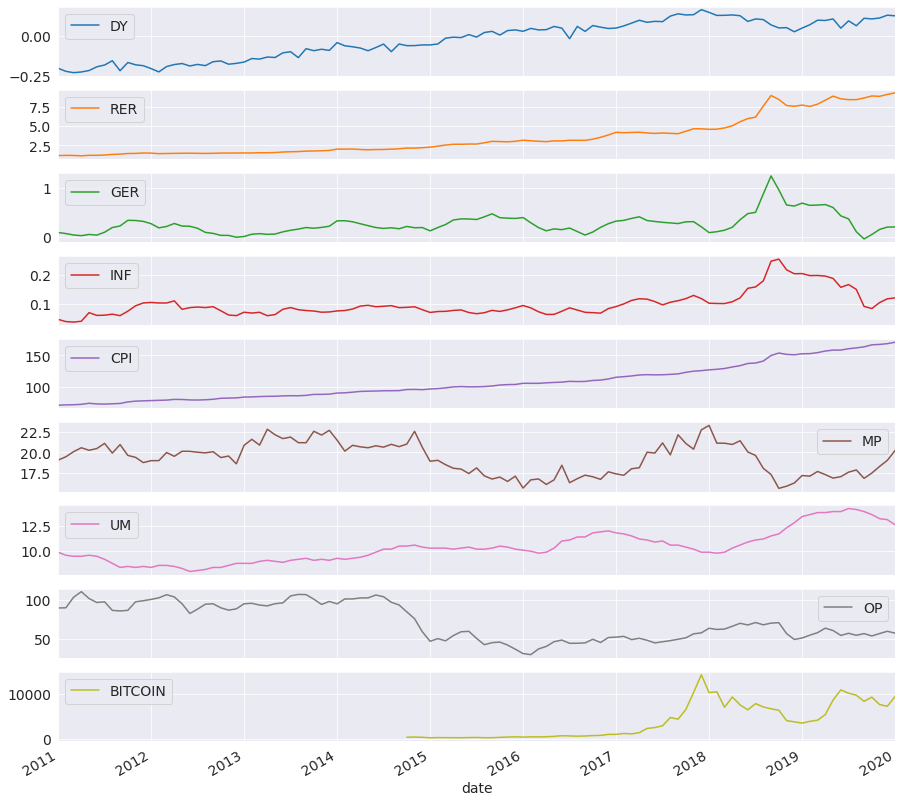

In [ ]:
# Plot
df_monthly.iloc[:,1:10].loc['2011-01-01':'2020-01-31'].plot(subplots=True, figsize=(15,15))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2804d02450>,
      dtype=object)

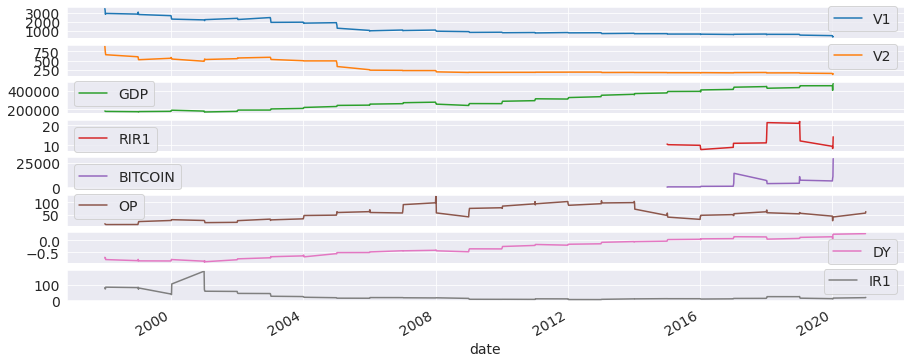

In [ ]:
df_quarterly.plot(subplots=True, figsize=(15,6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f28032bed50>],
      dtype=object)

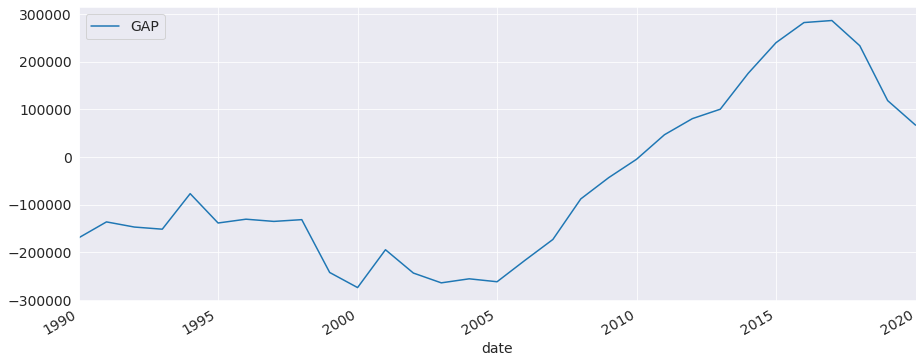

In [ ]:
df_yearly.plot(subplots=True, figsize=(15,6))

# **Stationarity (ADF tests)**

In [ ]:
#BITCOIN (stationary w/BIC, non stationary w/AIC)

result = adfuller(df_monthly.loc['2014-10-01':'2021-05-01'].BITCOIN.values, autolag='BIC',maxlag = 8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.355696025488045
p-value: 0.00035526130479680216
Critial Values:
   1%, -3.517113604831504
Critial Values:
   5%, -2.8993754262546574
Critial Values:
   10%, -2.5869547797501644


In [ ]:
#alternative test (KPSS Test) -> non-stationary
result = kpss(df_monthly.loc['2014-10-01':'2021-05-01'].BITCOIN.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.574891
p-value: 0.024919
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [ ]:
#BITCOIN quarterly (non stationary)

result = adfuller(df_quarterly.loc['2015-01-01':'2020-10-01'].BITCOIN.values, autolag='BIC',maxlag = 8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 0.09022230730910907
p-value: 0.9653871503378629
Critial Values:
   1%, -3.7529275211638033
Critial Values:
   5%, -2.998499866852963
Critial Values:
   10%, -2.6389669754253307


In [ ]:
#V1 (weak stationary)
result = adfuller(df_quarterly.V1.loc['1998-01-01':'2020-10-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.3391683473589775
p-value: 0.013215890262210487
Critial Values:
   1%, -3.5087828609430614
Critial Values:
   5%, -2.895783561573195
Critial Values:
   10%, -2.5850381719848565


In [ ]:
#V2 (non stationary)
result = adfuller(df_quarterly.V2.loc['1998-01-01':'2020-10-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.120032629250486
p-value: 0.23653604500162745
Critial Values:
   1%, -3.505190196159122
Critial Values:
   5%, -2.894232085048011
Critial Values:
   10%, -2.5842101234567902


In [ ]:
#CPI
result = adfuller(df_monthly.CPI.loc['1970-01-01':'2021-04-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 7.432815658286987
p-value: 1.0
Critial Values:
   1%, -3.441115625417986
Critial Values:
   5%, -2.866289751785392
Critial Values:
   10%, -2.56929951625907


In [ ]:
#INFLATION (non stationary)
result = adfuller(df_monthly.INF.loc['1970-01-01':'2021-04-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.402163022100091
p-value: 0.14112684216188276
Critial Values:
   1%, -3.4410451945636207
Critial Values:
   5%, -2.8662587328558566
Critial Values:
   10%, -2.569282988466721


In [ ]:
#IR1 (stationary w/BIC, non stationary w/AIC)
result = adfuller(df_monthly.IR1TY.loc['1993-01-01':'2021-04-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.659655306899167
p-value: 0.0001001317473956767
Critial Values:
   1%, -3.449846029628477
Critial Values:
   5%, -2.870129281376164
Critial Values:
   10%, -2.5713460670144603


In [ ]:
#alternative test (KPSS Test) -> pretty stationary
result = kpss(df_monthly.IR1TY.loc['1993-01-01':'2021-04-01'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 1.522225
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2080: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [ ]:
#IR1 quarterly (weak stationary)
result = adfuller(df_quarterly.IR1.loc['1998-01-01':'2021-04-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


ADF Statistic: -3.352909644502255
p-value: 0.012672834587386677
Critial Values:
   1%, -3.502704609582561
Critial Values:
   5%, -2.8931578098779522
Critial Values:
   10%, -2.583636712914788


In [ ]:
#RIR1 (non stationary)
result = adfuller(df_monthly.RIR1.loc['1993-01-01':'2021-04-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.857916290691249
p-value: 4.208504821325732e-05
Critial Values:
   1%, -3.449846029628477
Critial Values:
   5%, -2.870129281376164
Critial Values:
   10%, -2.5713460670144603


In [ ]:
#RIR1 quarterly (a little bit stationary)
result = adfuller(df_quarterly.RIR1.loc['2015-01-01':'2020-01-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.9696593603178454
p-value: 0.03782663145864756
Critial Values:
   1%, -4.137829282407408
Critial Values:
   5%, -3.1549724074074077
Critial Values:
   10%, -2.7144769444444443


In [ ]:
#alternative test (KPSS Test) -> non stationary
result = kpss(df_quarterly.RIR1.loc['2015-01-01':'2020-01-01'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.282216
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2084: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [ ]:
#OP (non stationary)
result = adfuller(df_monthly.OP.values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.5866276578509337
p-value: 0.09579267496250893
Critial Values:
   1%, -3.4410277306083668
Critial Values:
   5%, -2.8662510413264357
Critial Values:
   10%, -2.569278890210853


In [ ]:
#OP with linear trend included (stationarity at 5% level)
result = adfuller(df_monthly.OP.values, autolag = 'BIC', maxlag = 8,regression = 'ct')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
  print('Critical Values:')
  print(f'    {key},{value}')

ADF Statistic: -3.7966783224193454
p-value: 0.016729565648591342
Critical Values:
    1%,-3.9735662261569473
Critical Values:
    5%,-3.4176529473960255
Critical Values:
    10%,-3.131264701276341


In [ ]:
#OP quarterly (non stationary)
result = adfuller(df_quarterly.OP.loc['1998-01-01':'2021-04-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.616464039744381
p-value: 0.0896420039151738
Critial Values:
   1%, -3.503514579651927
Critial Values:
   5%, -2.893507960466837
Critial Values:
   10%, -2.583823615311909


In [ ]:
#RER (non stationary)
result = adfuller(df_monthly.RER.loc['1999-01-01':'2021-04-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 6.36964126955742
p-value: 1.0
Critial Values:
   1%, -3.4552699038400827
Critial Values:
   5%, -2.8725092359464526
Critial Values:
   10%, -2.5726152830188678


In [ ]:
df_quarterly.GDP

date
1998-01-01    180224.3966
1998-01-04    178788.8318
1998-01-07    176273.1390
1998-01-10    175817.1413
1999-01-01    172853.1804
                 ...     
2020-01-04    403722.2919
2020-01-07    468065.1967
2020-01-10    475901.2813
2021-01-01            NaN
2021-01-04            NaN
Name: GDP, Length: 94, dtype: float64

In [ ]:
#GDP (non stationary)
result = adfuller(df_quarterly.GDP.loc['1998-01-01':'2020-10-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 1.0627124190311328
p-value: 0.9948854813810671
Critial Values:
   1%, -3.505190196159122
Critial Values:
   5%, -2.894232085048011
Critial Values:
   10%, -2.5842101234567902


In [ ]:
#DY (non stationary)
result = adfuller(df_monthly.DY.loc['1979-11-01':'2021-02-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 0.3027720900651521
p-value: 0.9774713113439218
Critial Values:
   1%, -3.4437386290417082
Critial Values:
   5%, -2.867444458865948
Critial Values:
   10%, -2.5699148492415413


In [ ]:
#DY quarterly (non stationary)
result = adfuller(df_quarterly.DY.loc['2015-01-01':'2020-10-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.3905421956010016
p-value: 0.5868018160987807
Critial Values:
   1%, -3.7529275211638033
Critial Values:
   5%, -2.998499866852963
Critial Values:
   10%, -2.6389669754253307


In [ ]:
#UM (non stationary)
result = adfuller(df_monthly.UM.loc['2005-01-01':'2021-01-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.392035864098194
p-value: 0.14399685583845456
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476


In [ ]:
#MP (non stationary)
result = adfuller(df_monthly.MP.loc['2008-01-01':'2021-03-01'].values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.0922505239104425
p-value: 0.2476421009847517
Critial Values:
   1%, -3.4724305215713156
Critial Values:
   5%, -2.8800127935315465
Critial Values:
   10%, -2.576619230892485


In [ ]:
#GAP (non stationary)
result = adfuller(df_yearly.GAP.values, autolag='BIC', maxlag=8, regression='c')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


ADF Statistic: -1.103100037747512
p-value: 0.7138340638489749
Critial Values:
   1%, -3.6790595944893187
Critial Values:
   5%, -2.9678817237279103
Critial Values:
   10%, -2.6231583472057074


# **Differenciation**

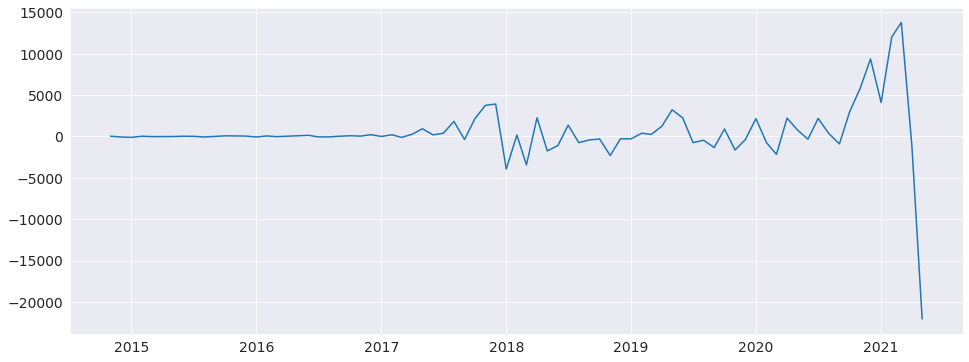

In [ ]:
# We have to differenciate the non-stationary series (BITCOIN, GAP, V1, V2, INFLATION,...)

#BITCOIN 
df_monthly['BITCOIN_d'] = df_monthly.BITCOIN.diff()
pyplot.plot(df_monthly.BITCOIN_d)
pyplot.show()

In [ ]:
#ADF of BITCOIN_d -> stationary
result = adfuller(df_monthly.loc['2014-11-01':'2021-05-01'].BITCOIN_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.629272199991027
p-value: 1.0989968494812622e-06
Critical Values:
   1%, -3.5219803175527606
Critical Values:
   5%, -2.9014701097664504
Critical Values:
   10%, -2.58807215485756


ADF Statistic: -5.629272199991027
p-value: 1.0989968494812622e-06
Critical Values:
   1%, -3.5219803175527606
Critical Values:
   5%, -2.9014701097664504
Critical Values:
   10%, -2.58807215485756


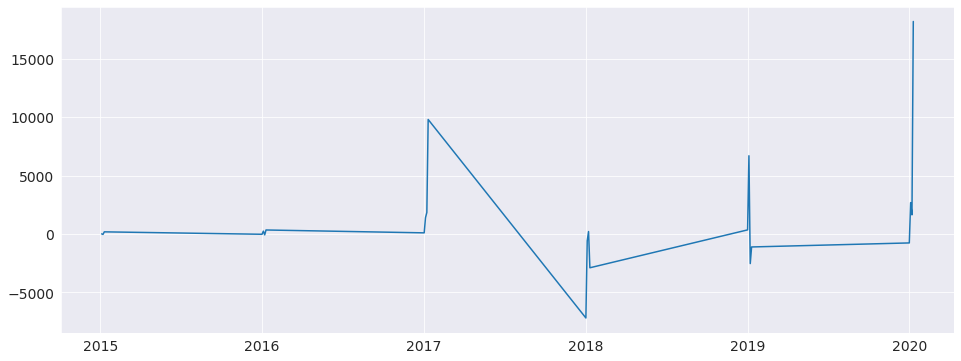

In [ ]:
#BITCOIN_d quarterly -> stationary
df_quarterly['BITCOIN_d'] = df_quarterly.BITCOIN.diff()

Result = adfuller(df_quarterly.loc['2015-04-01':'2020-10-01'].BITCOIN_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')
pyplot.plot(df_quarterly.BITCOIN_d)
pyplot.show()

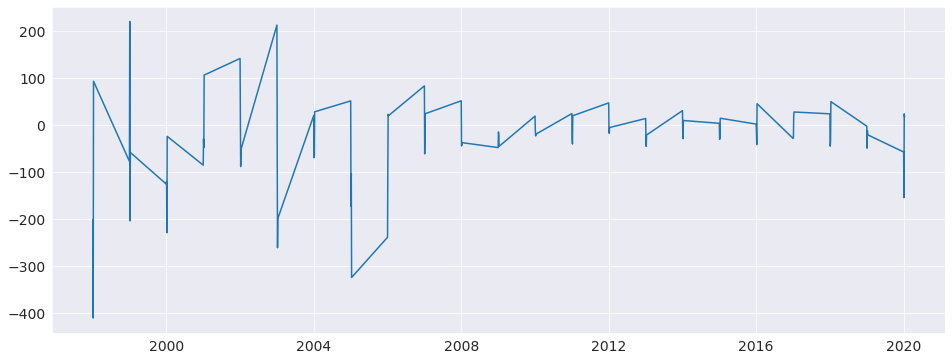

In [ ]:
#V1
df_quarterly['V1_d'] = df_quarterly.V1.diff()
pyplot.plot(df_quarterly.V1_d)
pyplot.show()

In [ ]:
#ADF of V1_d -> stationary
result = adfuller(df_quarterly.loc['1998-04-01':'2020-10-01'].V1_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.097599352553718
p-value: 1.0013257588494479e-07
Critial Values:
   1%, -3.5087828609430614
Critial Values:
   5%, -2.895783561573195
Critial Values:
   10%, -2.5850381719848565


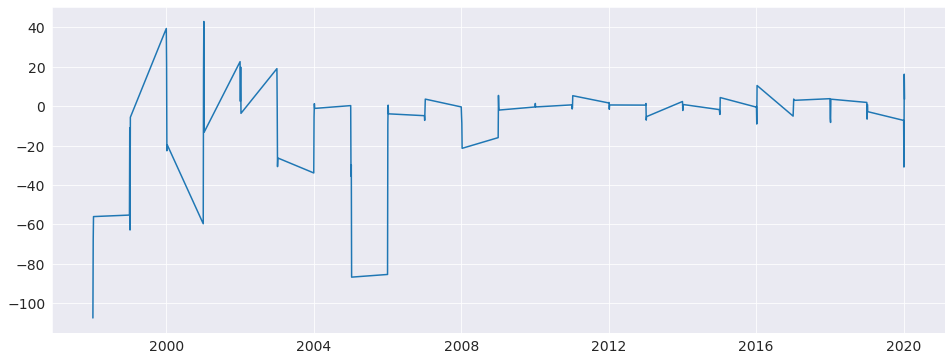

In [ ]:
#V2 
df_quarterly['V2_d'] = df_quarterly.V2.diff()
pyplot.plot(df_quarterly.V2_d)
pyplot.show()

In [ ]:
#ADF of V2_d -> stationary
result = adfuller(df_quarterly.loc['1998-04-01':'2020-10-01'].V2_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.5469060801892445
p-value: 9.051531045804471e-09
Critial Values:
   1%, -3.5078527246648834
Critial Values:
   5%, -2.895382030636155
Critial Values:
   10%, -2.584823877658872


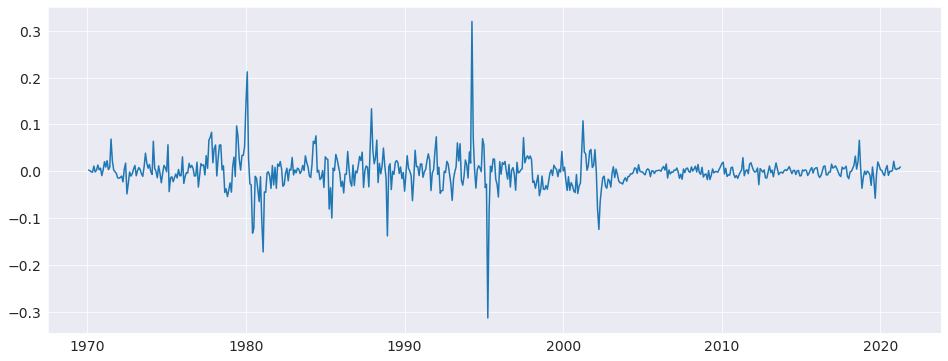

In [ ]:
#INFLATION
df_monthly['INF_d'] = df_monthly.INF.diff()
pyplot.plot(df_monthly.INF_d)
pyplot.show()

In [ ]:
#ADF of INF_d -> stationary
result = adfuller(df_monthly.loc['1970-02-01':'2021-04-01'].INF_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -15.76326437096942
p-value: 1.1847167768106745e-28
Critial Values:
   1%, -3.4410451945636207
Critial Values:
   5%, -2.8662587328558566
Critial Values:
   10%, -2.569282988466721


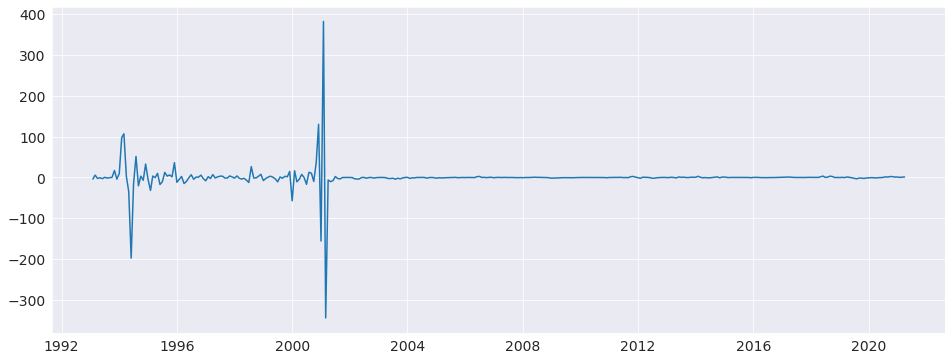

In [ ]:
#IR1
df_monthly['IR1TY_d'] = df_monthly.IR1TY.diff()
pyplot.plot(df_monthly.IR1TY_d)
pyplot.show()

In [ ]:
#ADF of IR1_d -> stationary
result = adfuller(df_monthly.loc['1993-02-01':'2021-04-01'].IR1TY_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -12.365966127584143
p-value: 5.413613807132607e-23
Critial Values:
   1%, -3.450081345901191
Critial Values:
   5%, -2.870232621465807
Critial Values:
   10%, -2.571401168202517


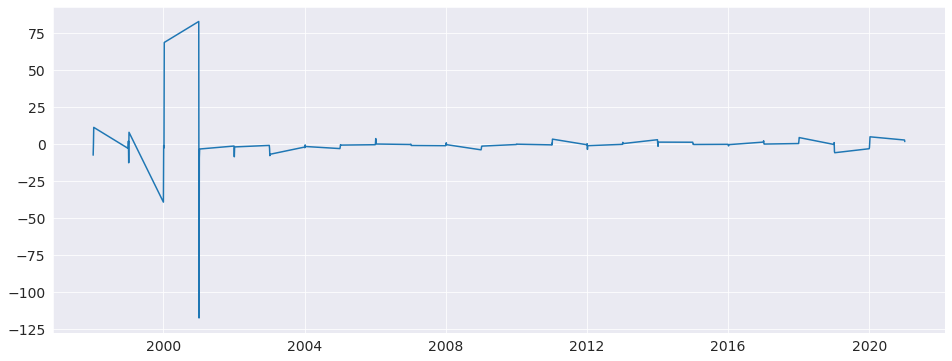

In [ ]:
#IR1 quarterly
df_quarterly['IR1_d'] = df_quarterly.IR1.diff()
pyplot.plot(df_quarterly.IR1_d)
pyplot.show()

In [ ]:
#ADF of IR1_d quarterly -> stationary
result = adfuller(df_quarterly.loc['1998-04-01':'2021-04-01'].IR1_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -7.791556546146736
p-value: 7.916970913883829e-12
Critial Values:
   1%, -3.5087828609430614
Critial Values:
   5%, -2.895783561573195
Critial Values:
   10%, -2.5850381719848565


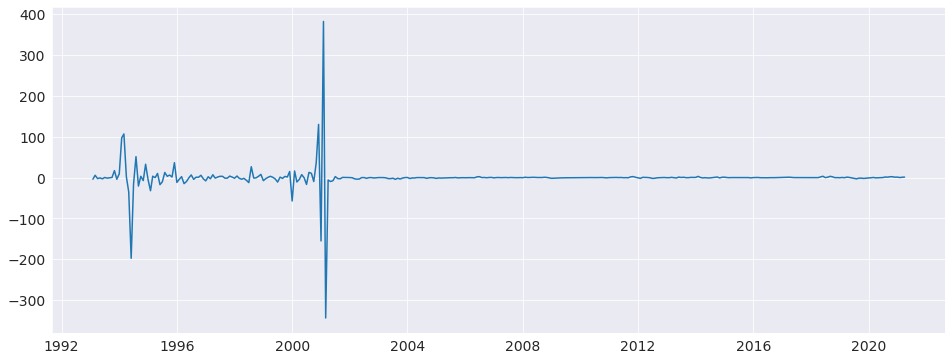

In [ ]:
#RIR1
df_monthly['RIR1_d'] = df_monthly.RIR1.diff()
pyplot.plot(df_monthly.RIR1_d)
pyplot.show()

In [ ]:
#ADF of RIR1_d -> stationary
result = adfuller(df_monthly.loc['1993-02-01':'2021-04-01'].RIR1_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -12.356147100000648
p-value: 5.68057819010083e-23
Critial Values:
   1%, -3.450081345901191
Critial Values:
   5%, -2.870232621465807
Critial Values:
   10%, -2.571401168202517


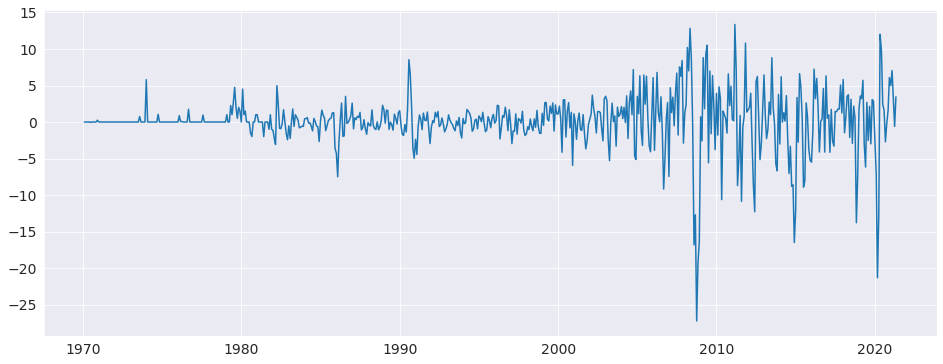

In [ ]:
#OP
df_monthly['OP_d'] = df_monthly.OP.diff()
pyplot.plot(df_monthly.OP_d)
pyplot.show()

In [ ]:
#ADF of OP_d -> stationary
result = adfuller(df_monthly.loc['1970-02-01':'2021-04-01'].OP_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -16.48187167341223
p-value: 2.2332910112802397e-29
Critial Values:
   1%, -3.4410451945636207
Critial Values:
   5%, -2.8662587328558566
Critial Values:
   10%, -2.569282988466721


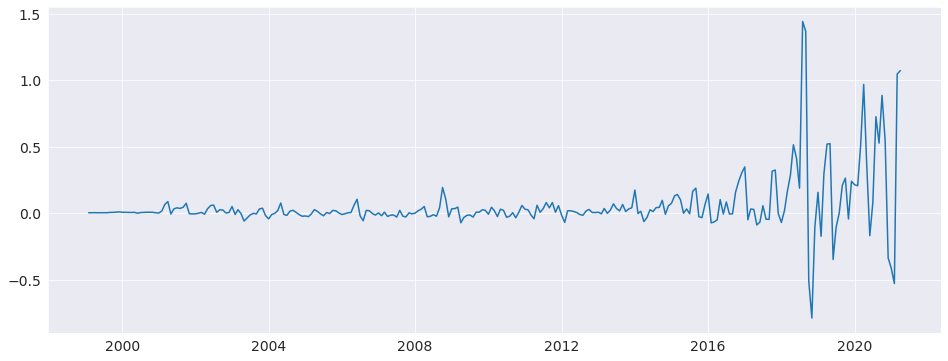

In [ ]:
#RER
df_monthly['RER_d'] = df_monthly.RER.diff()
pyplot.plot(df_monthly.RER_d)
pyplot.show()

In [ ]:
#ADF of RER_d -> stationary
result = adfuller(df_monthly.loc['1999-02-01':'2021-04-01'].RER_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -8.023480678048301
p-value: 2.0465949833551612e-12
Critial Values:
   1%, -3.455365238788105
Critial Values:
   5%, -2.8725510317187024
Critial Values:
   10%, -2.5726375763314966


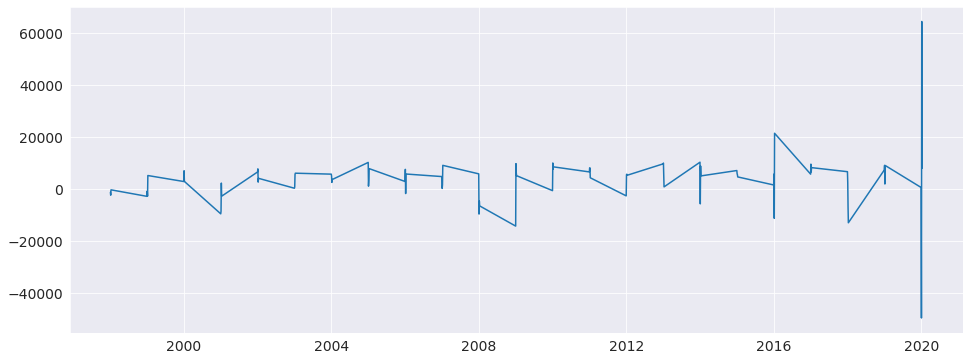

In [ ]:
#GDP
df_quarterly['GDP_d'] = df_quarterly.GDP.diff()
pyplot.plot(df_quarterly.GDP_d)
pyplot.show()

In [ ]:
#ADF of GDP_d -> stationary
result = adfuller(df_quarterly.loc['1998-04-01':'2020-10-01'].GDP_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -12.02221860648229
p-value: 3.005139307181591e-22
Critial Values:
   1%, -3.5078527246648834
Critial Values:
   5%, -2.895382030636155
Critial Values:
   10%, -2.584823877658872


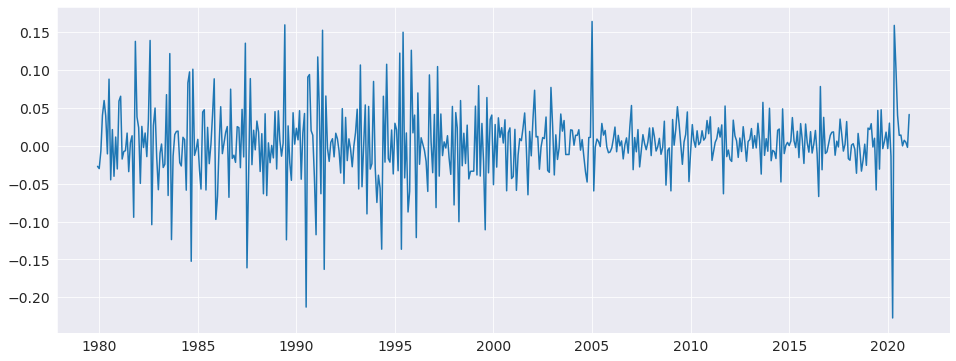

In [ ]:
#DY
df_monthly['DY_d'] = df_monthly.DY.diff()
pyplot.plot(df_monthly.DY_d)
pyplot.show()

In [ ]:
#ADF of DY_d -> stationary
result = adfuller(df_monthly.loc['1979-12-01':'2021-02-01'].DY_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -15.629097681859413
p-value: 1.6942067920828795e-28
Critial Values:
   1%, -3.4437386290417082
Critial Values:
   5%, -2.867444458865948
Critial Values:
   10%, -2.5699148492415413


In [ ]:
#ADF of DY_d quarterly -> stationary
df_quarterly['DY_d'] = df_quarterly.DY.diff()

result = adfuller(df_quarterly.loc['1998-04-01':'2021-01-01'].DY_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -12.630438630296261
p-value: 1.50897398297276e-23
Critial Values:
   1%, -3.506944401824286
Critial Values:
   5%, -2.894989819214876
Critial Values:
   10%, -2.584614550619835


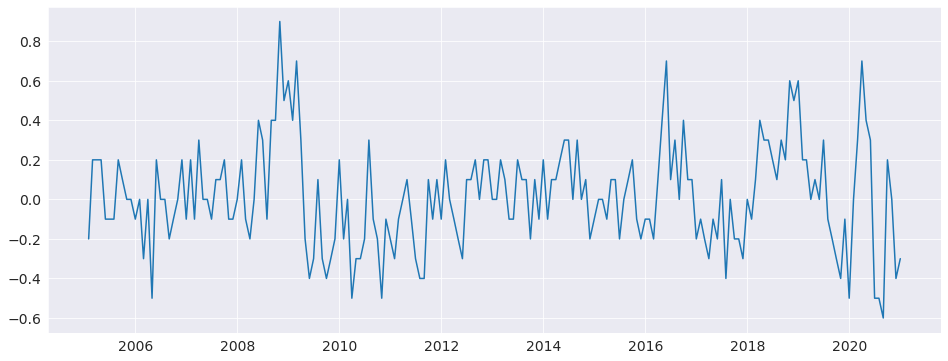

In [ ]:
#UM
df_monthly['UM_d'] = df_monthly.UM.diff()
pyplot.plot(df_monthly.UM_d)
pyplot.show()

In [ ]:
#ADF of UM_d -> stationary
result = adfuller(df_monthly.loc['2005-02-01':'2021-01-01'].UM_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.472709546714936
p-value: 0.0002202145014372601
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476


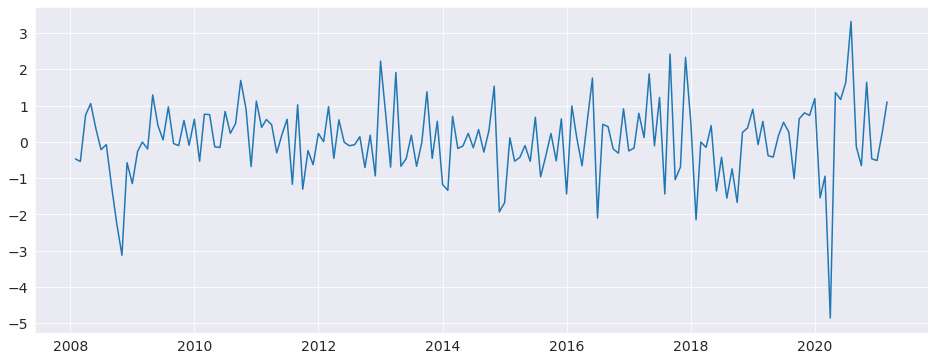

In [ ]:
#MP
df_monthly['MP_d'] = df_monthly.MP.diff()
pyplot.plot(df_monthly.MP_d)
pyplot.show()

In [ ]:
#ADF of MP_d -> stationary
result = adfuller(df_monthly.loc['2008-02-01':'2021-03-01'].MP_d.values, autolag='BIC', maxlag=8, regression='c') #constant model
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -12.441900022233556
p-value: 3.7372512009225533e-23
Critial Values:
   1%, -3.472703119504854
Critial Values:
   5%, -2.880131672353732
Critial Values:
   10%, -2.5766826861130268


# **Heteroskedasticity and Model selection**

In [ ]:
df_monthly['Time_Period'] = range(1, len(df_monthly)+1)
print(df_monthly.head(10))

                  date  DY  RER  GER  ...  DY_d  UM_d  MP_d  Time_Period
date                                  ...                               
1970-01-01  1970-01-01 NaN  NaN  NaN  ...   NaN   NaN   NaN            1
1970-02-01  1970-02-01 NaN  NaN  NaN  ...   NaN   NaN   NaN            2
1970-03-01  1970-03-01 NaN  NaN  NaN  ...   NaN   NaN   NaN            3
1970-04-01  1970-04-01 NaN  NaN  NaN  ...   NaN   NaN   NaN            4
1970-05-01  1970-05-01 NaN  NaN  NaN  ...   NaN   NaN   NaN            5
1970-06-01  1970-06-01 NaN  NaN  NaN  ...   NaN   NaN   NaN            6
1970-07-01  1970-07-01 NaN  NaN  NaN  ...   NaN   NaN   NaN            7
1970-08-01  1970-08-01 NaN  NaN  NaN  ...   NaN   NaN   NaN            8
1970-09-01  1970-09-01 NaN  NaN  NaN  ...   NaN   NaN   NaN            9
1970-10-01  1970-10-01 NaN  NaN  NaN  ...   NaN   NaN   NaN           10

[10 rows x 25 columns]


##### **BITCOIN**

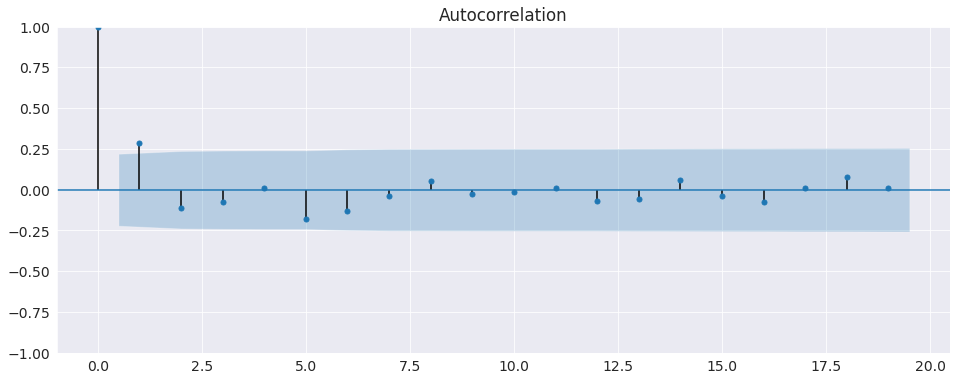

In [ ]:
# ACF plot

plot_acf(df_monthly.loc['2014-11-01':'2021-05-01'].BITCOIN_d)
pyplot.show() #1 lag

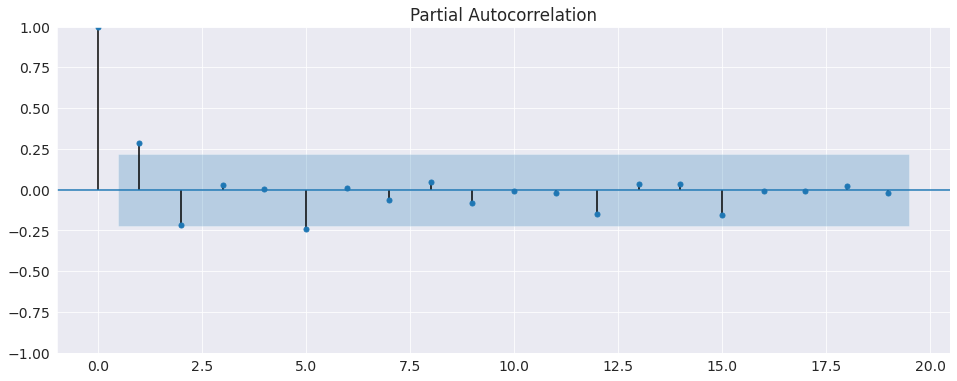

In [ ]:
# PACF

plot_pacf(df_monthly.loc['2014-11-01':'2021-05-01'].BITCOIN_d)
pyplot.show()

In [ ]:
#check whether it is necessary to upgrade statsmodels!
#!pip install statsmodels --upgrade

In [ ]:
# BITCOIN_d

model = pm.auto_arima(df_monthly.loc['2014-11-01':'2021-01-01'].BITCOIN_d, start_p=1, start_q=1, 
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=30, max_q=30, # maximum p and q
                      m=1,              # frequency of series (monthly)
                      d=0,      
                      seasonal=False,   # No Seasonality
                      information_criterion='bic',   #BIC criteria
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# We get an ARIMA(1,0,0)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=1345.666, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=1351.107, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=1342.303, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=1345.758, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=1345.461, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=1348.730, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=1344.634, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.383 seconds


In [ ]:
# Fit an AR model for BITCOIN_d with selected lags

# fit model
Y1 = df_monthly.loc['2014-11-01':'2021-05-01'].BITCOIN_d
model1 = ARIMA(Y1, order=(1,0,0))
model1_fit = model1.fit()

# summary of fit model
print(model1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              BITCOIN_d   No. Observations:                   79
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -754.905
Date:                Sat, 26 Jun 2021   AIC                           1515.811
Time:                        14:09:14   BIC                           1522.919
Sample:                    11-01-2014   HQIC                          1518.658
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        447.5858   1291.477      0.347      0.729   -2083.663    2978.834
ar.L1          0.5182      0.095      5.481      0.000       0.333       0.703
sigma2      1.178e+07   9.01e+05     13.078      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:538: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:538: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:538: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


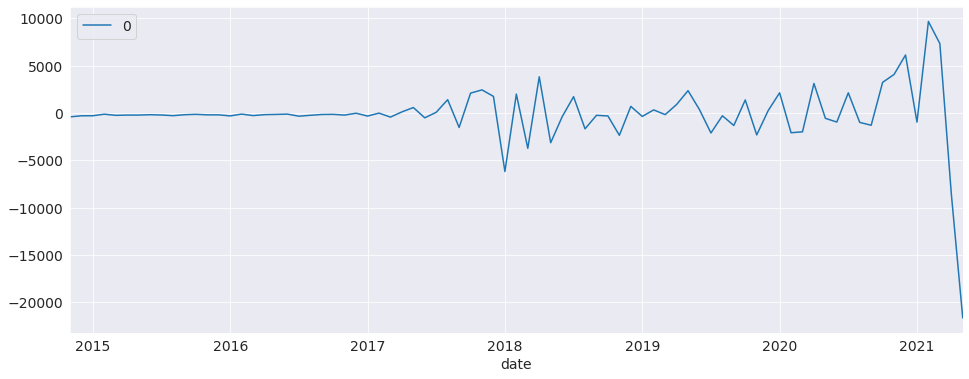

In [ ]:
#line plot of residuals with selected lags

residuals1 = DataFrame(model1_fit.resid)
residuals1.plot()
pyplot.show()

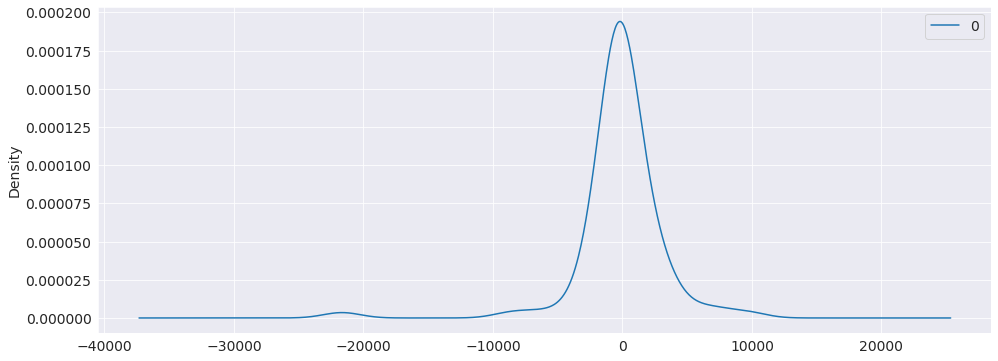

In [ ]:
# density plot of residuals with lags selected
residuals1.plot(kind='kde')
pyplot.show()

#we get a density plot of the residual error values, 
#suggesting the errors are Gaussian, but may not be centered on zero.

In [ ]:
# summary stats of residuals
print(residuals1.describe())

#the results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

                  0
count     79.000000
mean    -147.580169
std     3429.823835
min   -21662.672976
25%     -420.146034
50%     -195.140529
75%      468.165165
max     9676.715252


In [ ]:
# Execute the Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH) with selected lags
keys1 = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results1 = het_arch(residuals1, ddof=1) #1 lag
lzip(keys1, results1)
# Reject Ho (no ARCH)

[('Lagrange Multiplier statistic:', 56.23915904755337),
 ("LM test's p-value:", 1.0840093785002904e-07),
 ('F-statistic:', 25.927706121525784),
 ("F-test's p-value:", 3.618468243140517e-18)]

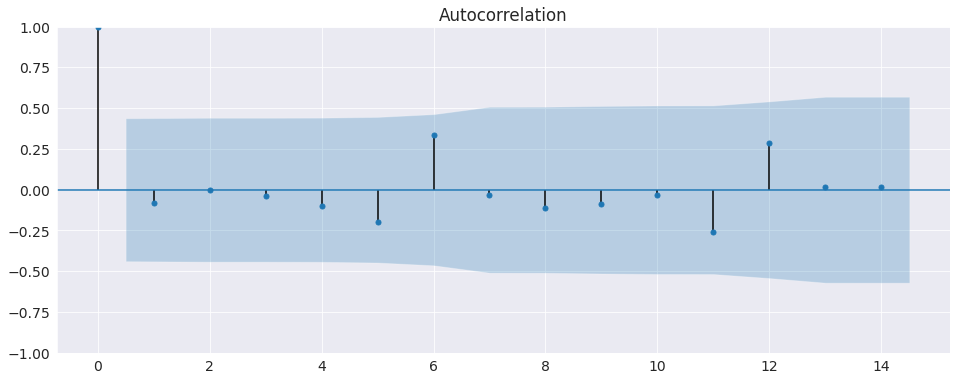

In [ ]:
# BITCOIN quarterly
# ACF plot

plot_acf(df_quarterly.loc['2015-04-01':'2020-10-01'].BITCOIN_d)
pyplot.show() #0 lags

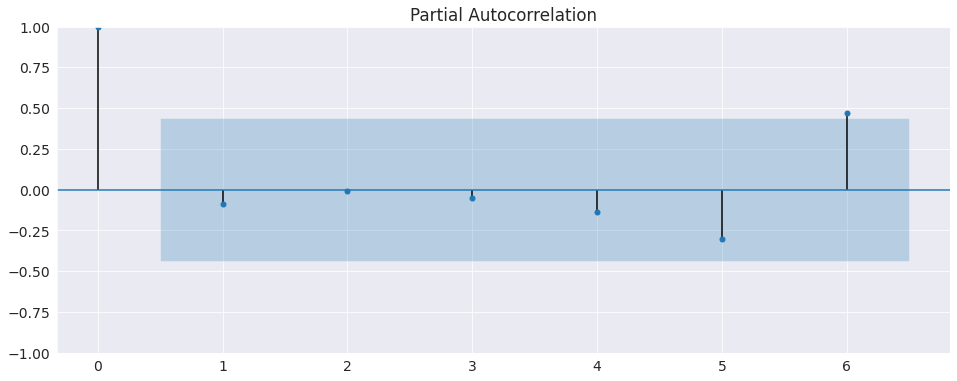

In [ ]:
# PACF plot

plot_pacf(df_quarterly.loc['2015-04-01':'2020-10-01'].BITCOIN_d, lags=6)
pyplot.show() #0 lag

In [ ]:
# BITCOIN quarterly

model = pm.auto_arima(df_quarterly.loc['2015-04-01':'2020-10-01'].BITCOIN_d, start_p=1, start_q=1, 
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=30, max_q=30, # maximum p and q
                      m=4,              # frequency of series (quarterlyy)
                      d=0,      
                      seasonal=False,   # No Seasonality
                      information_criterion='bic',   #BIC criteria
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# We get an ARIMA(0,0,0)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=402.614, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=405.542, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=405.985, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=404.089, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.135 seconds


In [ ]:
# Fit an AR model for BITCOIN_d with selected lags

# fit model
Y1 = df_quarterly.loc['2015-04-01':'2020-10-01'].BITCOIN_d
model1 = ARIMA(Y1, order=(0,0,0))
model1_fit = model1.fit()

# summary of fit model
print(model1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              BITCOIN_d   No. Observations:                   20
Model:                          ARIMA   Log Likelihood                -199.051
Date:                Sat, 26 Jun 2021   AIC                            402.102
Time:                        14:09:16   BIC                            404.093
Sample:                             0   HQIC                           402.491
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1428.5554   1699.984      0.840      0.401   -1903.353    4760.463
sigma2      2.636e+07    7.3e+06      3.613      0.000    1.21e+07    4.07e+07
Ljung-Box (L1) (Q):                   0.16   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:594: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:594: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:594: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


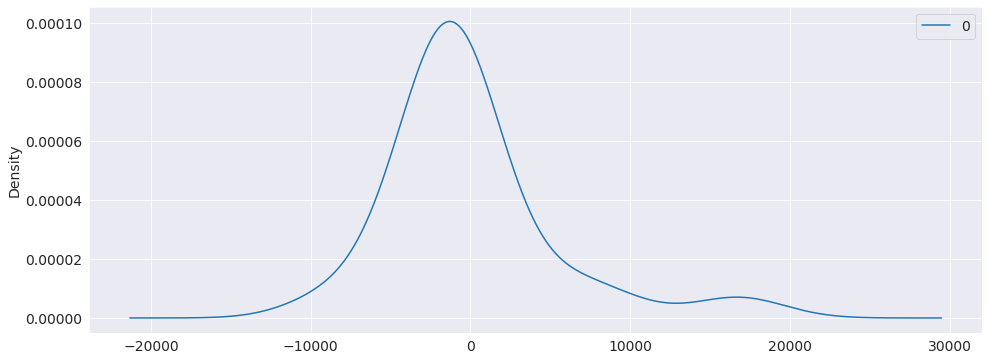

In [ ]:
# density plot of residuals with lags selected

residuals1 = DataFrame(model1_fit.resid)
residuals1.plot(kind='kde')
pyplot.show()

In [ ]:
# Execute the Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH) with selected lags
keys1 = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results1 = het_arch(residuals1, ddof=0) #0 lag
lzip(keys1, results1)

# NO Reject Ho (no ARCH)

[('Lagrange Multiplier statistic:', 9.55111918518237),
 ("LM test's p-value:", 0.3880301674861112),
 ('F-statistic:', 0.732451871932503),
 ("F-test's p-value:", 0.7273569343695483)]

#####**INFLATION**

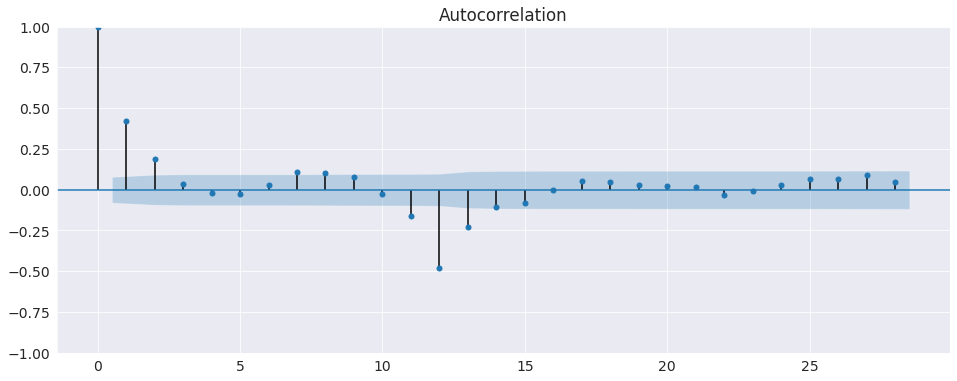

In [ ]:
# ACF plot
Y = df_monthly.loc['1970-02-01':'2021-04-01']

plot_acf(Y.INF_d)
pyplot.show()

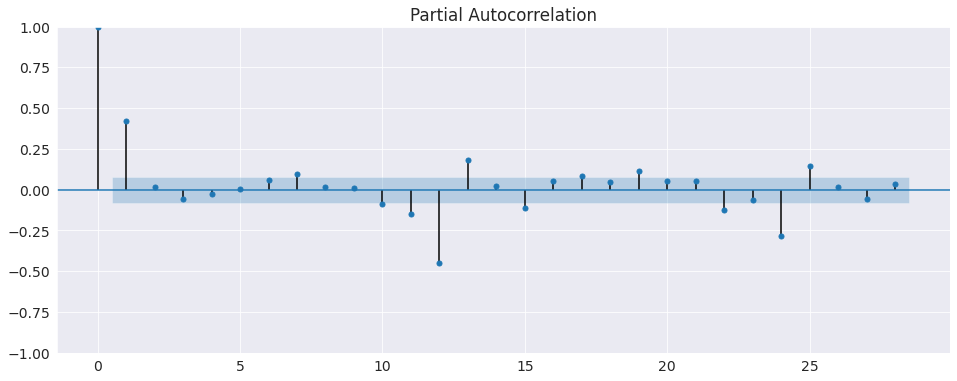

In [ ]:
plot_pacf(Y.INF_d)
pyplot.show()

In [ ]:
# INFLATION

model = pm.auto_arima(df_monthly.loc['1970-02-01':'2021-04-01'].INF_d, start_p=1, start_q=1, 
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=30, max_q=30, # maximum p and q
                      m=1,              # frequency of series (monthly)
                      d=None,
                      seasonal=None,   # Seasonality
                      information_criterion='bic',   #BIC criteria
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# We get and ARIMA(1,0,0)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-2472.231, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-2364.303, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=-2478.548, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=-2456.460, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=-2472.262, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-2466.367, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-2472.133, Time=0.17 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.138 seconds


In [ ]:
# Fit an AR(1) for INF_d with selected lags

# fit model
Y2 = df_monthly.loc['1970-02-01':'2021-04-01'].INF_d.values
model1 = ARIMA(Y2, order=(14,0,0))
model1_fit = model1.fit()

# summary of fit model
print(model1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  615
Model:                ARIMA(14, 0, 0)   Log Likelihood                1334.005
Date:                Sat, 26 Jun 2021   AIC                          -2636.009
Time:                        14:09:22   BIC                          -2565.263
Sample:                             0   HQIC                         -2608.500
                                - 615                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.084      0.933      -0.003       0.004
ar.L1          0.4059      0.033     12.278      0.000       0.341       0.471
ar.L2          0.0433      0.038      1.139      0.2

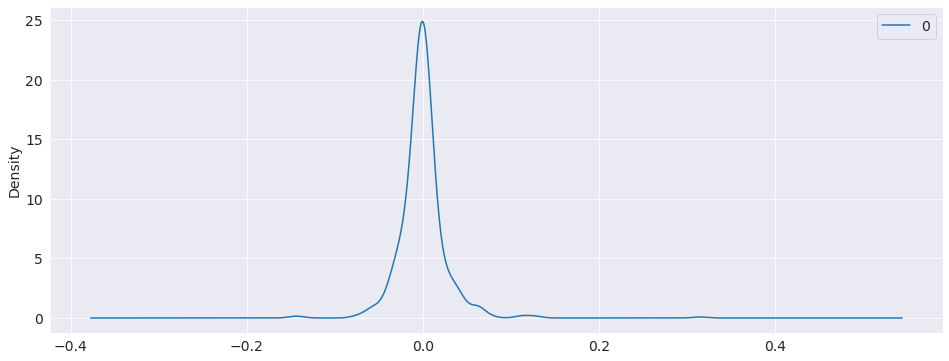

In [ ]:
# density plot of residuals with selected lags
residuals1 = DataFrame(model1_fit.resid)
residuals1.plot(kind='kde')
pyplot.show()

In [ ]:
# Execute the Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH) with selected lags = 1
results1 = het_arch(residuals1, ddof=1) #1 lag
lzip(keys1, results1)

#It’s p-value is very low 
#-> we reject the null hypothesis that there is no heteroscedastisticity in the residual errors (No ARCH).

[('Lagrange Multiplier statistic:', 34.069051017298214),
 ("LM test's p-value:", 0.01803598438157249),
 ('F-statistic:', 1.8412786459398431),
 ("F-test's p-value:", 0.016208380292078984)]

#####**RER**



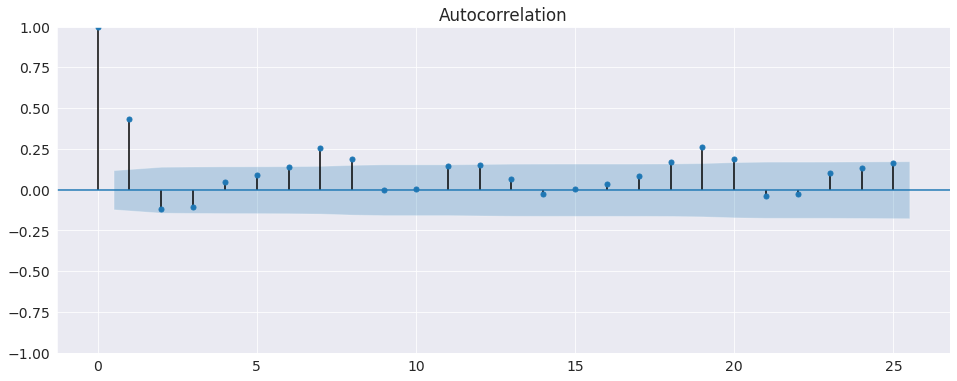

In [ ]:
# ACF plot
Y = df_monthly.loc['1999-02-01':'2021-04-01'].RER_d
plot_acf(Y)
pyplot.show() 

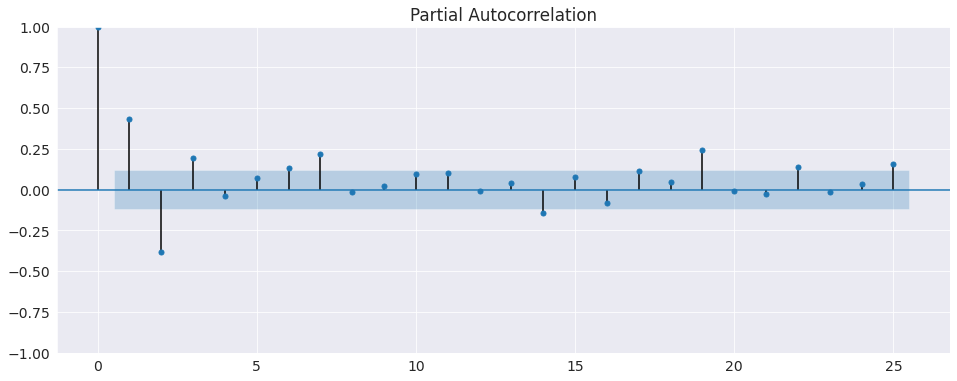

In [ ]:
plot_pacf(Y)
pyplot.show() 

In [ ]:
# RER

model = pm.auto_arima(df_monthly.loc['1999-02-01':'2021-04-01'].RER_d, start_p=1, start_q=1, 
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=30, max_q=30, # maximum p and q
                      m=1,              # frequency of series (monthly)
                      d=0,      
                      seasonal=False,   # No Seasonality
                      information_criterion='bic',   #BIC criteria
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# We get and ARIMA(1,0,2)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-132.866, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-32.805, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=-98.625, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=-137.625, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=-133.355, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-141.824, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : BIC=-128.282, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[0]             : BIC=-136.936, Time=0.31 sec
 ARIMA(0,0,3)(0,0,0)[0]             : BIC=-131.527, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-131.671, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : BIC=inf, Time=0.87 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=-130.082, Time=0.45 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 2.768 seconds


In [ ]:
# Fit an ARIMA(1,0,2) for RER_d with selected lags

# fit model
Y3 = df_monthly.loc['1999-02-01':'2021-04-01'].RER_d.values
model3 = ARIMA(Y3, order=(1,0,2))
model3_fit = model3.fit()

# summary of fit model
print(model3_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  267
Model:                 ARIMA(1, 0, 2)   Log Likelihood                  79.009
Date:                Sat, 26 Jun 2021   AIC                           -148.018
Time:                        14:09:27   BIC                           -130.082
Sample:                             0   HQIC                          -140.814
                                - 267                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0554      0.031      1.761      0.078      -0.006       0.117
ar.L1          0.4826      1.194      0.404      0.686      -1.857       2.822
ma.L1          0.1702      1.187      0.143      0.8

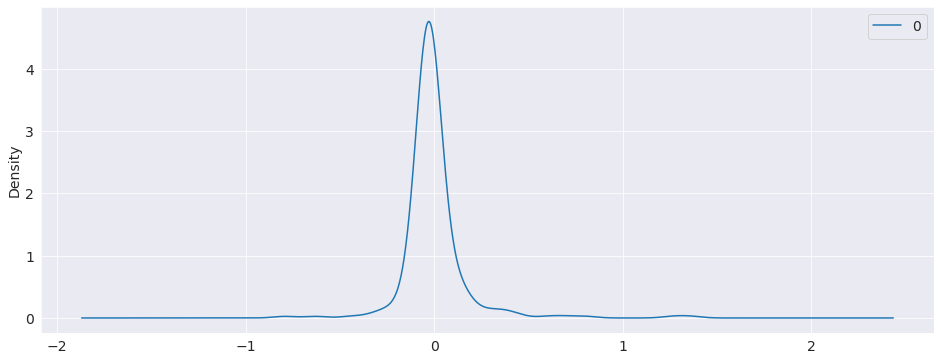

In [ ]:
# density plot of residuals with selected lags
residuals3 = DataFrame(model3_fit.resid)
residuals3.plot(kind = 'kde')
pyplot.show()

In [ ]:
# Execute the Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH) with selected lags
keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results3 = het_arch(residuals3, ddof=3) 
lzip(keys, results3)

#It’s p-value is very low -> we reject the null hypothesis that there is no heteroscedastisticity in the residual errors (No ARCH).
#we reject the null hypothesis of the test that there is no heteroscedastisticity in the residual errors.

[('Lagrange Multiplier statistic:', 44.42387490380834),
 ("LM test's p-value:", 0.00017001182968902012),
 ('F-statistic:', 3.191431068654087),
 ("F-test's p-value:", 5.6093353341834524e-05)]

##### **V1**

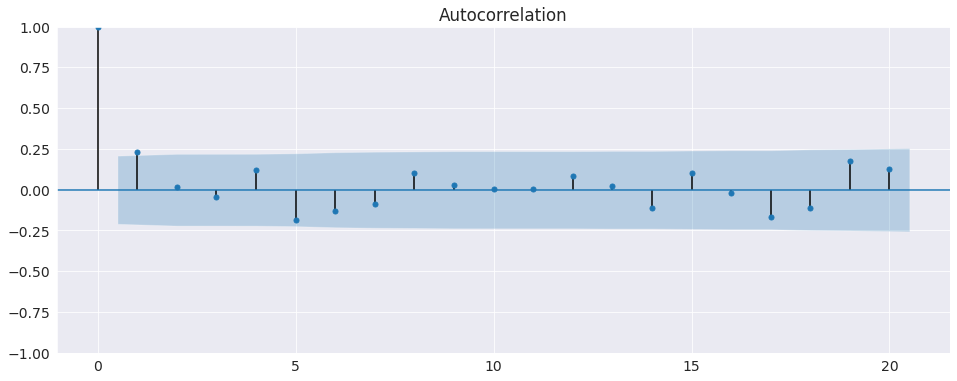

In [ ]:
# ACF plot
Y = df_quarterly.loc['1998-02-01':'2020-10-01'].V1_d
plot_acf(Y)
pyplot.show() 

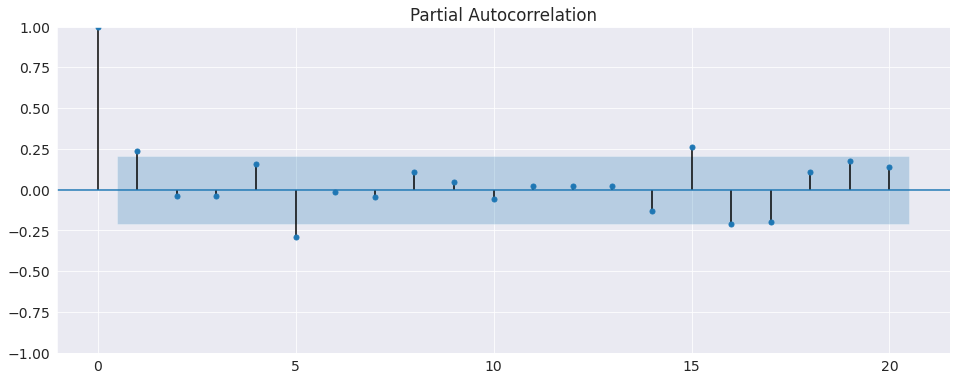

In [ ]:
plot_pacf(Y)
pyplot.show() 

In [ ]:
# V1 (quarterly data)

model = pm.auto_arima(Y, start_p=1, start_q=1, 
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=30, max_q=30, # maximum p and q
                      m=4,              # frequency of series (quarterly)
                      d=0,      
                      seasonal=False,   # No Seasonality
                      information_criterion='bic',   #BIC criteria
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# We get and ARIMA(1,0,2)


Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=1044.368, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=1044.483, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=1039.978, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=1041.184, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=1044.390, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=1046.033, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=1038.840, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=1039.254, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=1043.122, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=1043.192, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=1038.834, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : BIC=1043.097, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=1035.546, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : 

In [ ]:
# Fit an ARIMA(1,0,2) for V1 with selected lags (quarterly data)

# fit model
model4 = ARIMA(Y.values, order=(1,0,2))
model4_fit = model4.fit()

# summary of fit model
print(model4_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   88
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -506.580
Date:                Sat, 26 Jun 2021   AIC                           1023.160
Time:                        14:09:30   BIC                           1035.547
Sample:                             0   HQIC                          1028.150
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.8370     14.759     -1.954      0.051     -57.763       0.089
ar.L1         -0.9720      0.015    -64.150      0.000      -1.002      -0.942
ma.L1          1.5186      0.076     20.015      0.0

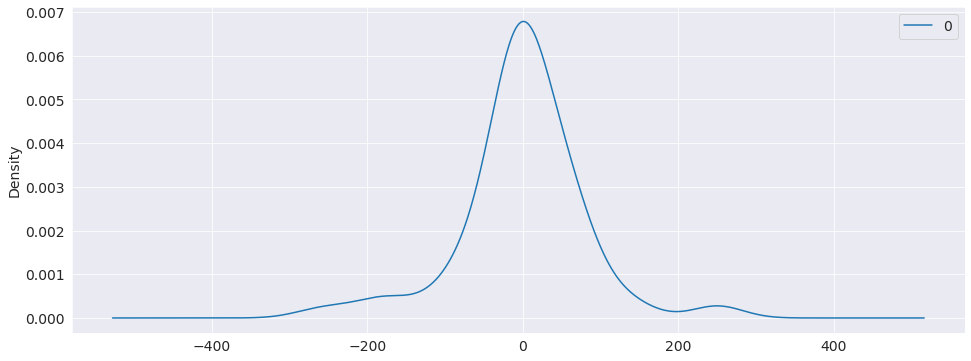

In [ ]:
# density plot of residuals with selected lags
residuals4 = DataFrame(model4_fit.resid)
residuals4.plot(kind='kde')
pyplot.show()

In [ ]:
# Execute the Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH) with selected lags

results4 = het_arch(residuals4, ddof=3) #3 lags
lzip(keys, results4)
#It’s p-value is very low -> we reject the null hypothesis that there is no heteroscedastisticity in the residual errors (No ARCH).
#we reject the null hypothesis of the test that there is no heteroscedastisticity in the residual errors.

[('Lagrange Multiplier statistic:', 31.149848486196895),
 ("LM test's p-value:", 0.0018689603409845245),
 ('F-statistic:', 3.9076729387370484),
 ("F-test's p-value:", 0.00017473091033879822)]

##### **V2**

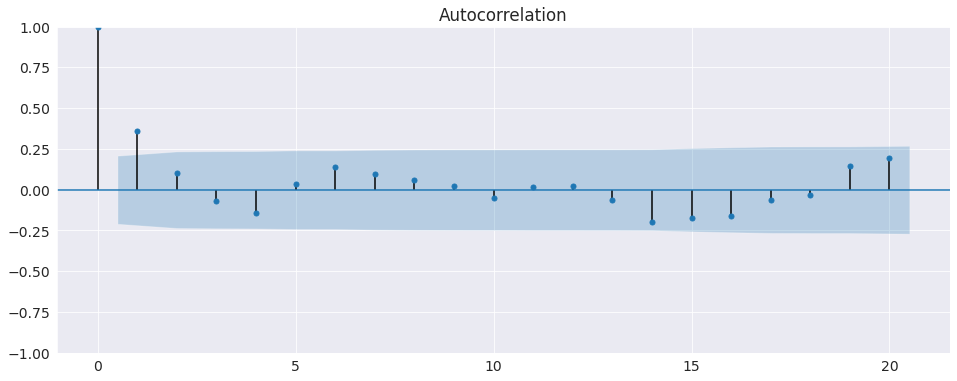

In [ ]:
# ACF plot
Y = df_quarterly.loc['1998-04-01':'2020-10-01'].V2_d
plot_acf(Y)
pyplot.show() 

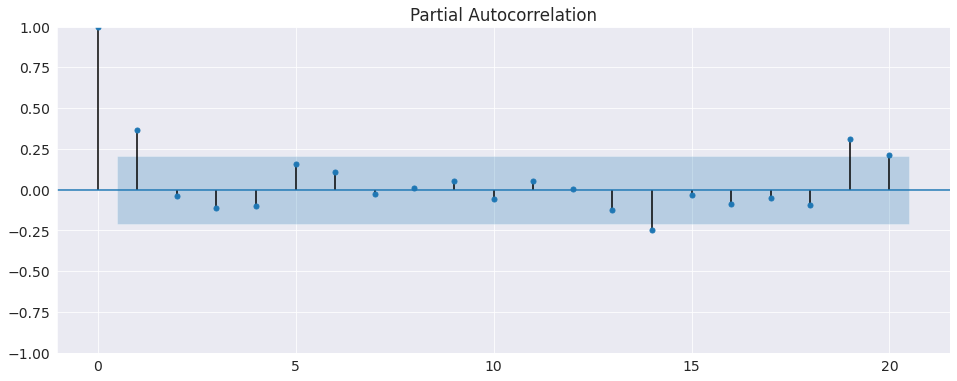

In [ ]:
plot_pacf(Y)
pyplot.show()

In [ ]:
# V2 (quarterly data)

model = pm.auto_arima(Y, start_p=1, start_q=1, 
                      test='adf',        # use adftest to find optimal 'd'
                      max_p=30, max_q=30, # maximum p and q
                      m=4,              # frequency of series (quarterly)
                      d=0,      
                      seasonal=False,   # No Seasonality
                      information_criterion='bic',   #BIC criteria
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# We get and ARIMA(1,0,0)

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=784.752, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=792.723, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=780.278, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=782.662, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=784.752, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=789.233, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=781.513, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.486 seconds


In [ ]:
# Fit an AR(1) for V2_d with selected lags(quarterly data) 

# fit model
Y5 = df_quarterly.loc['1998-04-01':'2020-10-01'].V2.values
model5 = ARIMA(Y5, order=(1,0,0))
model5_fit = model5.fit()

# summary of fit model
print(model5_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   88
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -393.413
Date:                Sat, 26 Jun 2021   AIC                            792.826
Time:                        14:09:32   BIC                            800.258
Sample:                             0   HQIC                           795.820
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        359.9933    219.851      1.637      0.102     -70.907     790.893
ar.L1          0.9955      0.017     58.423      0.000       0.962       1.029
sigma2       424.1286     32.589     13.015      0.0

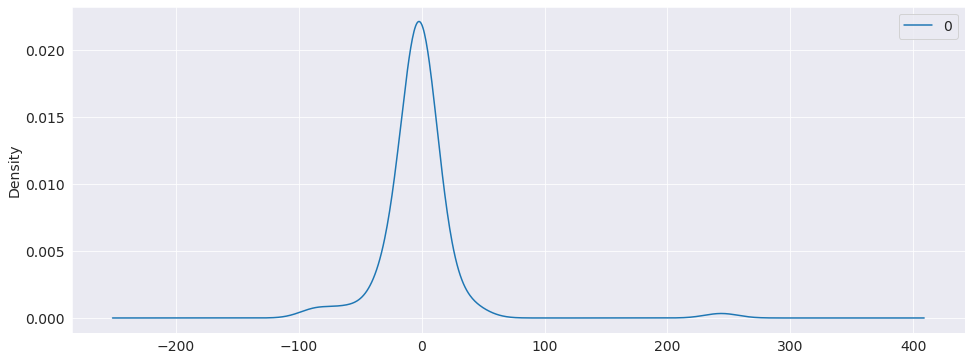

In [ ]:
# density plot of residuals with selected lags 
residuals5 = DataFrame(model5_fit.resid)
residuals5.plot(kind = 'kde')
pyplot.show()

In [ ]:
# Execute the Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH) with selected lags

results5 = het_arch(residuals5, ddof=1) # 1 lag
lzip(keys, results5)

#It’s p-value is very low -> we reject the null hypothesis that there is no heteroscedastisticity in the residual errors (No ARCH).
#we reject the null hypothesis of the test that there is no heteroscedastisticity in the residual errors.

[('Lagrange Multiplier statistic:', 27.097896119825148),
 ("LM test's p-value:", 0.007480269075894398),
 ('F-statistic:', 2.969889485124692),
 ("F-test's p-value:", 0.002460450074690515)]

# **GARCH Modeling**

#### **BITCOIN ARIMA (1,1,0) GARCH(1,1)**


In [ ]:
# We compute the ARIMA(1,1,0) GARCH(1,1) variance of the BPG.

Y=df_monthly.loc['2014-11-01':'2021-01-01'].BITCOIN_d #dependent variable

ar = ARX(Y, lags=[1]) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

# residuals
residuals = DataFrame(res.resid)

                           AR - GARCH Model Results                           
Dep. Variable:              BITCOIN_d   R-squared:                       0.122
Mean Model:                        AR   Adj. R-squared:                  0.110
Vol Model:                      GARCH   Log-Likelihood:               -613.553
Distribution:                  Normal   AIC:                           1237.11
Method:            Maximum Likelihood   BIC:                           1248.63
                                        No. Observations:                   74
Date:                Sat, Jun 26 2021   Df Residuals:                       72
Time:                        14:09:33   Df Model:                            2
                                 Mean Model                                 
                   coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------------------------------------------
Const           40.3082     23.874      1.688  9.134e-02  

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &     BITCOIN\_d     & \textbf{  R-squared:         } &     0.122   \\
\textbf{Mean Model:}    &         AR         & \textbf{  Adj. R-squared:    } &     0.110   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &   -613.553  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &    1237.11  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &    1248.63  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     74      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     72      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                       & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}         &      40.3082  &       23.874     &     1.688  &      9.134e-02       &     [ -6

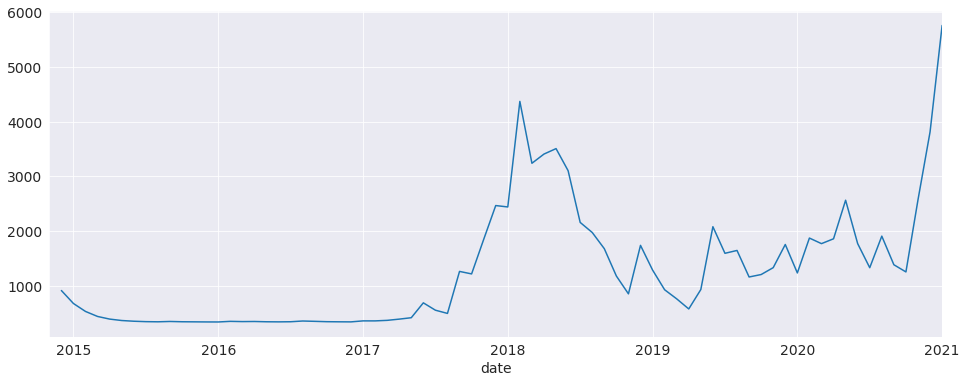

In [ ]:
#Conditional volatility

df_monthly['BITCOIN_var'] = res.conditional_volatility
fig = res.conditional_volatility.plot()

In [ ]:
# We compute the ARIMA(1,1,0) GARCH(1,1) variance of the BPG.

Y=df_monthly.loc['2014-11-01':'2021-01-01'].BITCOIN_d #dependent variable

ar = ARX(Y, lags=[1]) # Mean model

from arch.univariate import StudentsT

ar.distribution = StudentsT() # t distribution
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())


                              AR - GARCH Model Results                              
Dep. Variable:                    BITCOIN_d   R-squared:                       0.031
Mean Model:                              AR   Adj. R-squared:                  0.018
Vol Model:                            GARCH   Log-Likelihood:               -607.133
Distribution:      Standardized Student's t   AIC:                           1226.27
Method:                  Maximum Likelihood   BIC:                           1240.09
                                              No. Observations:                   74
Date:                      Sat, Jun 26 2021   Df Residuals:                       72
Time:                              14:09:33   Df Model:                            2
                                Mean Model                                
                   coef    std err          t      P>|t|  95.0% Conf. Int.
--------------------------------------------------------------------------
Const     

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &        BITCOIN\_d        & \textbf{  R-squared:         } &     0.031   \\
\textbf{Mean Model:}    &            AR            & \textbf{  Adj. R-squared:    } &     0.018   \\
\textbf{Vol Model:}     &          GARCH           & \textbf{  Log-Likelihood:    } &   -607.133  \\
\textbf{Distribution:}  & Standardized Student's t & \textbf{  AIC:               } &    1226.27  \\
\textbf{Method:}        &    Maximum Likelihood    & \textbf{  BIC:               } &    1240.09  \\
\textbf{}               &                          & \textbf{  No. Observations:  } &     74      \\
\textbf{Date:}          &     Sat, Jun 26 2021     & \textbf{  Df Residuals:      } &     72      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                       & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}         &      36.1935  &       16.495     &   

####**BITCOIN ARIMA (0,1,0) GARCH(1,1)**

In [ ]:
# We compute the ARIMA(0,1,0) GARCH(1,1) variance of the BPG quarterly

Y=df_quarterly.loc['2015-04-01':'2020-10-01'].BITCOIN_d #dependent variable

ar = ARX(Y) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

# residuals
residuals = DataFrame(res.resid)

                           AR - GARCH Model Results                           
Dep. Variable:              BITCOIN_d   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -198.129
Distribution:                  Normal   AIC:                           404.257
Method:            Maximum Likelihood   BIC:                           408.240
                                        No. Observations:                   20
Date:                Sat, Jun 26 2021   Df Residuals:                       19
Time:                        14:09:33   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const       1428.5572   1271.886      1.123      0.261 

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &     BITCOIN\_d     & \textbf{  R-squared:         } &     0.000   \\
\textbf{Mean Model:}    &         AR         & \textbf{  Adj. R-squared:    } &     0.000   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &   -198.129  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &    404.257  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &    408.240  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     20      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     19      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
               & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const} &    1428.5572  &     1271.886     &     1.123  &          0.261       &   [-1.064e+03,3.921e+03]

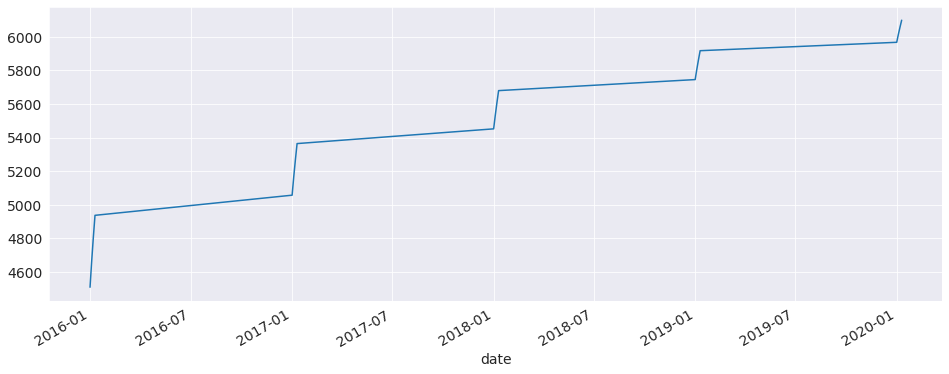

In [ ]:
#Conditional volatility

df_quarterly['BITCOIN_var'] = res.conditional_volatility
fig = res.conditional_volatility.plot()

#### **INFLATION models**

In [ ]:
# MODEL 1.1: INFLATION without BITCOIN price

Y=df_monthly.loc['2014-11-01':'2021-01-01'].INF_d #dependent variable
X=df_monthly.loc['2014-11-01':'2021-01-01'][["UM_d", "MP_d", "OP_d"]] #exogenous variables (UM, MP, OP)

ar = ARX(Y, X, lags=[1]) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                  INF_d   R-squared:                       0.132
Mean Model:                      AR-X   Adj. R-squared:                  0.081
Vol Model:                      GARCH   Log-Likelihood:                222.307
Distribution:                  Normal   AIC:                          -428.614
Method:            Maximum Likelihood   BIC:                          -410.181
                                        No. Observations:                   74
Date:                Sat, Jun 26 2021   Df Residuals:                       69
Time:                        14:09:34   Df Model:                            5
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const       6.9160e-04  1.019e-03      0.679      0.

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       INF\_d       & \textbf{  R-squared:         } &     0.132   \\
\textbf{Mean Model:}    &        AR-X        & \textbf{  Adj. R-squared:    } &     0.081   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &    222.307  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &   -428.614  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &   -410.181  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     74      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     69      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                   & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}     &   6.9160e-04  &    1.019e-03     &     0.679  &          0.497       &   [-1.306e-03,2.

In [ ]:
# MODEL 1.1: INFLATION without BITCOIN price w/lags 1, 2

Y=df_monthly.loc['2014-11-01':'2021-01-01'].INF_d #dependent variable
X=df_monthly.loc['2014-11-01':'2021-01-01'][["UM_d", "MP_d", "OP_d"]] #exogenous variables (UM, MP, OP)

ar = ARX(Y, X, lags=[1, 2]) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                  INF_d   R-squared:                       0.200
Mean Model:                      AR-X   Adj. R-squared:                  0.140
Vol Model:                      GARCH   Log-Likelihood:                223.069
Distribution:                  Normal   AIC:                          -428.139
Method:            Maximum Likelihood   BIC:                          -407.525
                                        No. Observations:                   73
Date:                Sat, Jun 26 2021   Df Residuals:                       67
Time:                        14:09:34   Df Model:                            6
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const       9.1489e-04  9.521e-04      0.961      0.

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       INF\_d       & \textbf{  R-squared:         } &     0.200   \\
\textbf{Mean Model:}    &        AR-X        & \textbf{  Adj. R-squared:    } &     0.140   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &    223.069  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &   -428.139  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &   -407.525  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     73      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     67      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                   & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}     &   9.1489e-04  &    9.521e-04     &     0.961  &          0.337       &   [-9.511e-04,2.

In [ ]:
# MODEL 1.1: INFLATION without BITCOIN price w/lag 1 and leads 1, 2 #BEST

df_monthly[["INF_d_1"]] = df_monthly[["INF_d"]].shift(periods=1)
df_monthly[["INF_d_2"]] = df_monthly[["INF_d"]].shift(periods=2)

Y=df_monthly.loc['2014-11-01':'2021-01-01'].INF_d #dependent variable
X=df_monthly.loc['2014-11-01':'2021-01-01'][["UM_d", "MP_d", "OP_d", "INF_d_1", "INF_d_2"]] #exogenous variables (UM, MP, OP)

ar = ARX(Y, X, lags=[1]) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                  INF_d   R-squared:                       0.195
Mean Model:                      AR-X   Adj. R-squared:                  0.122
Vol Model:                      GARCH   Log-Likelihood:                226.658
Distribution:                  Normal   AIC:                          -433.317
Method:            Maximum Likelihood   BIC:                          -410.276
                                        No. Observations:                   74
Date:                Sat, Jun 26 2021   Df Residuals:                       67
Time:                        14:09:34   Df Model:                            7
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const       7.5719e-04  9.465e-04      0.800      0.

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       INF\_d       & \textbf{  R-squared:         } &     0.195   \\
\textbf{Mean Model:}    &        AR-X        & \textbf{  Adj. R-squared:    } &     0.122   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &    226.658  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &   -433.317  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &   -410.276  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     74      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     67      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                   & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}     &   7.5719e-04  &    9.465e-04     &     0.800  &          0.424       &   [-1.098e-03,2.

In [ ]:
# MODEL 1.1: INFLATION without BITCOIN price w/lags 1, 2 and leads 1, 2 #WORST

df_monthly[["INF_d_1"]] = df_monthly[["INF_d"]].shift(periods=1)
df_monthly[["INF_d_2"]] = df_monthly[["INF_d"]].shift(periods=2)

Y=df_monthly.loc['2014-11-01':'2021-01-01'].INF_d #dependent variable
X=df_monthly.loc['2014-11-01':'2021-01-01'][["UM_d", "MP_d", "OP_d", "INF_d_1", "INF_d_2"]] #exogenous variables (UM, MP, OP)

ar = ARX(Y, X, lags=[1, 2]) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                  INF_d   R-squared:                       0.203
Mean Model:                      AR-X   Adj. R-squared:                  0.118
Vol Model:                      GARCH   Log-Likelihood:                222.540
Distribution:                  Normal   AIC:                          -423.080
Method:            Maximum Likelihood   BIC:                          -397.885
                                        No. Observations:                   73
Date:                Sat, Jun 26 2021   Df Residuals:                       65
Time:                        14:09:34   Df Model:                            8
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const       9.1608e-04  8.223e-04      1.114      0.

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       INF\_d       & \textbf{  R-squared:         } &     0.203   \\
\textbf{Mean Model:}    &        AR-X        & \textbf{  Adj. R-squared:    } &     0.118   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &    222.540  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &   -423.080  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &   -397.885  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     73      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     65      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                   & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}     &   9.1608e-04  &    8.223e-04     &     1.114  &          0.265       &   [-6.956e-04,2.

In [ ]:
# MODEL 1.2: INFLATION with BITCOIN price

Y=df_monthly.loc['2014-11-01':'2021-01-01'].INF_d #dependent variable
X=df_monthly.loc['2014-11-01':'2021-01-01'][["UM_d", "MP_d", "OP_d", "BITCOIN_d"]] #exogenous variables (UM, MP, OP and BITCOIN)

ar = ARX(Y, X, lags=([1])) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                  INF_d   R-squared:                    -982.073
Mean Model:                      AR-X   Adj. R-squared:              -1054.358
Vol Model:                      GARCH   Log-Likelihood:               -92.6211
Distribution:                  Normal   AIC:                           203.242
Method:            Maximum Likelihood   BIC:                           223.979
                                        No. Observations:                   74
Date:                Sat, Jun 26 2021   Df Residuals:                       68
Time:                        14:09:35   Df Model:                            6
                                  Mean Model                                 
                  coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------------------------------------
Const           0.0377      0.361      0.104      0.917

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:752: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       INF\_d       & \textbf{  R-squared:         } &  -982.073   \\
\textbf{Mean Model:}    &        AR-X        & \textbf{  Adj. R-squared:    } & -1054.358   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &   -92.6211  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &    203.242  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &    223.979  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     74      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     68      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                    & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}      &       0.0377  &        0.361     &     0.104  &          0.917       &     [ -0.670, 

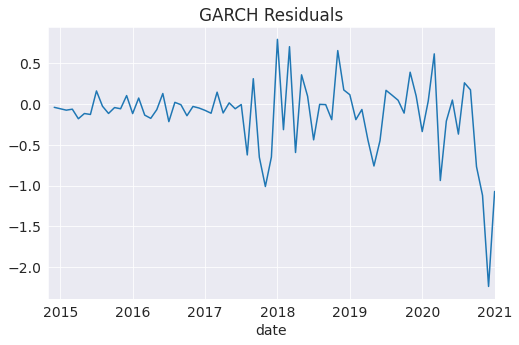

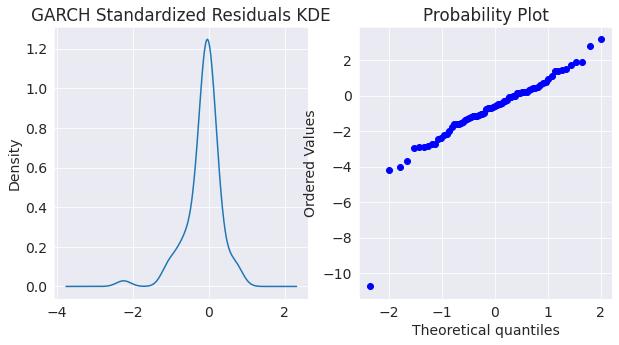

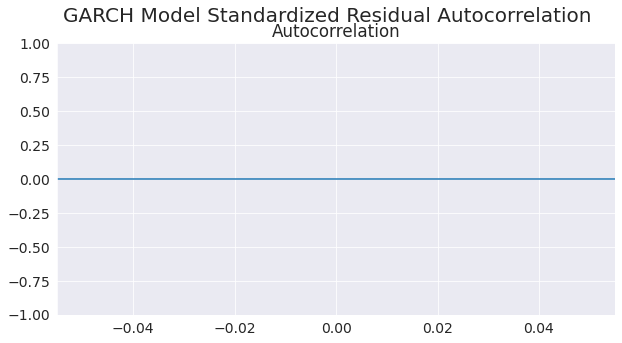

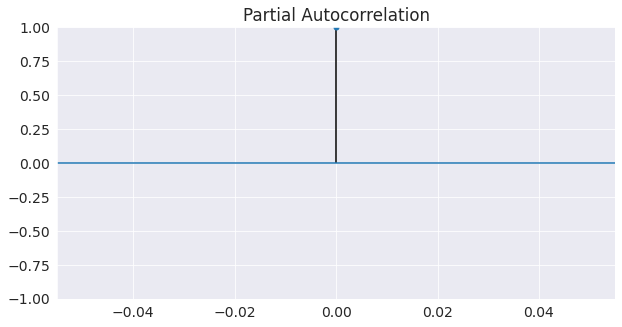

In [ ]:
#Diagnosis plots

resid = res.resid
st_resid = np.divide(resid, res.conditional_volatility)

ts_plot(resid, st_resid)

In [ ]:
#arch_test = het_arch(resid, maxlag=6)
shapiro_test = shapiro(st_resid)
#print(f'Lagrange mulitplier p-value: {arch_test[1]}')
#print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

Shapiro-Wilks p-value: 1.0


In [ ]:
# MODEL 1.2: INFLATION with BITCOIN price w/lags 1, 2 #BEST

Y=df_monthly.loc['2014-11-01':'2021-01-01'].INF_d #dependent variable
X=df_monthly.loc['2014-11-01':'2021-01-01'][["UM_d", "MP_d", "OP_d", "BITCOIN_d"]] #exogenous variables (UM, MP, OP and BITCOIN)

ar = ARX(Y, X, lags=([1, 2])) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                  INF_d   R-squared:                 -441716.796
Mean Model:                      AR-X   Adj. R-squared:            -481872.959
Vol Model:                      GARCH   Log-Likelihood:               -1944.09
Distribution:                  Normal   AIC:                           3908.18
Method:            Maximum Likelihood   BIC:                           3931.08
                                        No. Observations:                   73
Date:                Sat, Jun 26 2021   Df Residuals:                       66
Time:                        14:09:36   Df Model:                            7
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
Const       9.3271e-03      0.923  1.010e-02     

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       INF\_d       & \textbf{  R-squared:         } & -441716.796  \\
\textbf{Mean Model:}    &        AR-X        & \textbf{  Adj. R-squared:    } & -481872.959  \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &    -1944.09  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &     3908.18  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &     3931.08  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &      73      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &      66      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                    & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}      &   9.3271e-03  &        0.923     & 1.010e-02  &          0.992       &     [ -

In [ ]:
# MODEL 1.2: INFLATION with BITCOIN price w/lags 1 and leads 1

Y=df_monthly.loc['2014-11-01':'2021-01-01'].INF_d #dependent variable
X=df_monthly.loc['2014-11-01':'2021-01-01'][["UM_d", "MP_d", "OP_d", "BITCOIN_d", "INF_d_1"]] #exogenous variables (UM, MP, OP and BITCOIN)

ar = ARX(Y, X, lags=([1])) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                  INF_d   R-squared:                     -23.291
Mean Model:                      AR-X   Adj. R-squared:                -25.466
Vol Model:                      GARCH   Log-Likelihood:                113.494
Distribution:                  Normal   AIC:                          -206.989
Method:            Maximum Likelihood   BIC:                          -183.948
                                        No. Observations:                   74
Date:                Sat, Jun 26 2021   Df Residuals:                       67
Time:                        14:09:37   Df Model:                            7
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
Const       5.6043e-04  4.634e-03      0.121     

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       INF\_d       & \textbf{  R-squared:         } &   -23.291   \\
\textbf{Mean Model:}    &        AR-X        & \textbf{  Adj. R-squared:    } &   -25.466   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &    113.494  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &   -206.989  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &   -183.948  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     74      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     67      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                    & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}      &   5.6043e-04  &    4.634e-03     &     0.121  &          0.904       &   [-8.521e-03,

In [ ]:
# MODEL 1.3: INFLATION with BITCOIN GARCH volatility w/lags 1, 2 #BEST

Y=df_monthly.loc['2014-12-01':'2021-01-01'].INF_d #dependent variable
X=df_monthly.loc['2014-12-01':'2021-01-01'][["UM_d", "MP_d", "OP_d", "BITCOIN_var"]] #exogenous variables (UM, MP, OP and BITCOIN)

ar = ARX(Y, X, lags=[1,2]) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                  INF_d   R-squared:                    -197.066
Mean Model:                      AR-X   Adj. R-squared:               -215.350
Vol Model:                      GARCH   Log-Likelihood:               -3.86353
Distribution:                  Normal   AIC:                           27.7271
Method:            Maximum Likelihood   BIC:                           50.4937
                                        No. Observations:                   72
Date:                Sat, Jun 26 2021   Df Residuals:                       65
Time:                        14:09:37   Df Model:                            7
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const       -6.9680e-04      0.103 -6.758e-03    

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       INF\_d       & \textbf{  R-squared:         } &  -197.066   \\
\textbf{Mean Model:}    &        AR-X        & \textbf{  Adj. R-squared:    } &  -215.350   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &   -3.86353  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &    27.7271  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &    50.4937  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     72      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     65      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                      & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}        &  -6.9680e-04  &        0.103     & -6.758e-03 &          0.995       &     [ -0.2

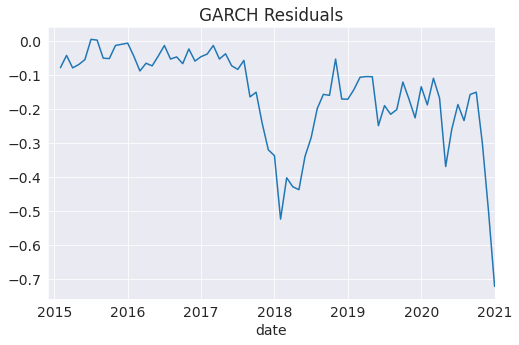

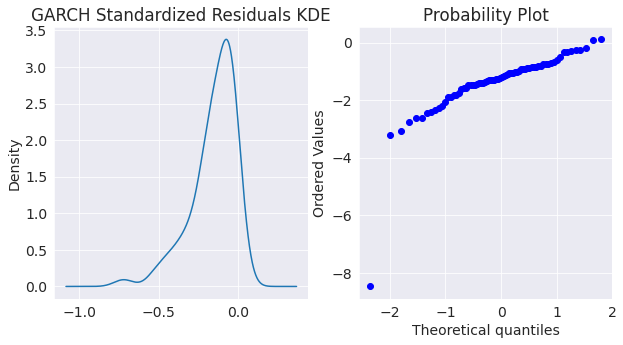

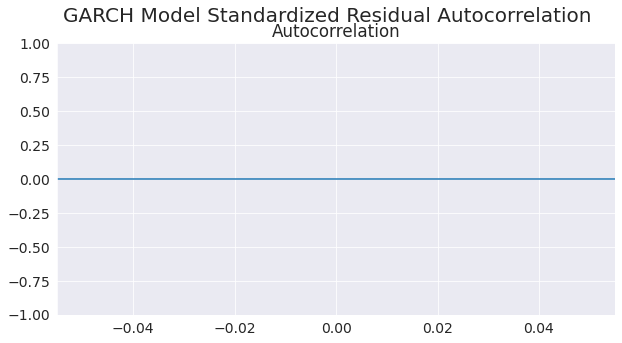

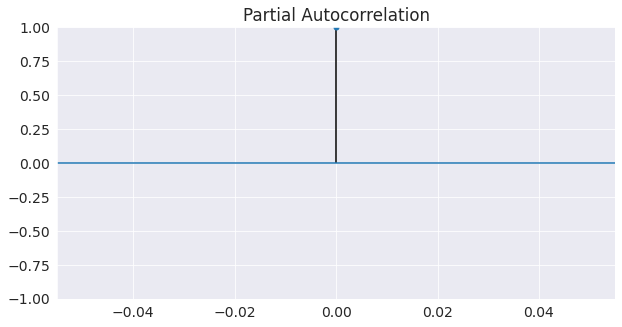

Shapiro-Wilks p-value: 1.0


In [ ]:
#Diagnosis plots

resid = res.resid
st_resid = np.divide(resid, res.conditional_volatility)

ts_plot(resid, st_resid)
#arch_test = het_arch(resid, maxlag=12)
shapiro_test = shapiro(st_resid)
#print(f'Lagrange mulitplier p-value: {arch_test[1]}')
#print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

In [ ]:
# MODEL 1.3: INFLATION with BITCOIN GARCH volatility w/lag 1 and leads 1, 2 #WORST

Y=df_monthly.loc['2014-12-01':'2021-01-01'].INF_d #dependent variable
X=df_monthly.loc['2014-12-01':'2021-01-01'][["UM_d", "MP_d", "OP_d", "BITCOIN_var", 'INF_d_1', 'INF_d_2']] #exogenous variables (UM, MP, OP and BITCOIN)

ar = ARX(Y, X, lags=[1]) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                  INF_d   R-squared:                     -98.074
Mean Model:                      AR-X   Adj. R-squared:               -108.744
Vol Model:                      GARCH   Log-Likelihood:                84.3786
Distribution:                  Normal   AIC:                          -146.757
Method:            Maximum Likelihood   BIC:                          -121.562
                                        No. Observations:                   73
Date:                Sat, Jun 26 2021   Df Residuals:                       65
Time:                        14:09:38   Df Model:                            8
                                   Mean Model                                   
                   coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------------------------------------------------------
Const            0.0362  5.183e-03      6.992 

In [ ]:
# MODEL 1.3: INFLATION with BITCOIN GARCH volatility w/lags 1 and leads 1, 2

Y=df_monthly.loc['2014-12-01':'2021-01-01'].INF_d #dependent variable
X=df_monthly.loc['2014-12-01':'2021-01-01'][["UM_d", "MP_d", "OP_d", "BITCOIN_var"]] #exogenous variables (UM, MP, OP and BITCOIN)

ar = ARX(Y, X, lags=[1]) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                  INF_d   R-squared:                     -33.425
Mean Model:                      AR-X   Adj. R-squared:                -35.994
Vol Model:                      GARCH   Log-Likelihood:                52.3795
Distribution:                  Normal   AIC:                          -86.7590
Method:            Maximum Likelihood   BIC:                          -66.1448
                                        No. Observations:                   73
Date:                Sat, Jun 26 2021   Df Residuals:                       67
Time:                        14:09:39   Df Model:                            6
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const       -9.6990e-04  2.017e-02 -4.810e-02    

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       INF\_d       & \textbf{  R-squared:         } &   -33.425   \\
\textbf{Mean Model:}    &        AR-X        & \textbf{  Adj. R-squared:    } &   -35.994   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &    52.3795  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &   -86.7590  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &   -66.1448  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     73      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     67      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                      & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}        &  -9.6990e-04  &    2.017e-02     & -4.810e-02 &          0.962       &   [-4.049e

#### **RER models**

In [ ]:
# MODEL 2.1: RER without BITCOIN price
# We compute the ARIMA(1,1,2) GARCH(1,1) model

Y=df_monthly.loc['2014-11-01':'2021-01-01'].RER_d #dependent variable
X=df_monthly.loc['2014-11-01':'2021-01-01'][["DY_d", "RIR1_d", "OP_d"]] #exogenous variables

# Mean Model
model = ARIMA(Y, X, order=(1,0,2))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# residuals
residuals = DataFrame(model_fit.resid)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:538: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:538: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:538: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  RER_d   No. Observations:                   75
Model:                 ARIMA(1, 0, 2)   Log Likelihood                  -5.140
Date:                Sat, 26 Jun 2021   AIC                             26.279
Time:                        14:09:39   BIC                             44.819
Sample:                    11-01-2014   HQIC                            33.682
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1314      0.078      1.680      0.093      -0.022       0.285
DY_d           0.0297      0.583      0.051      0.959      -1.112       1.172
RIR1_d         0.1511      0.032      4.673      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
print(model_fit.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &      RER\_d      & \textbf{  No. Observations:  } &     75      \\
\textbf{Model:}                  &  ARIMA(1, 0, 2)  & \textbf{  Log Likelihood     } &   -5.140    \\
\textbf{Date:}                   & Sat, 26 Jun 2021 & \textbf{  AIC                } &   26.279    \\
\textbf{Time:}                   &     14:09:39     & \textbf{  BIC                } &   44.819    \\
\textbf{Sample:}                 &    11-01-2014    & \textbf{  HQIC               } &   33.682    \\
\textbf{}                        &   - 01-01-2021   & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                 & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}   &       0.1314  &        0.078     &     1.680  &         0.093        &       -0.022    &        0.285     \\
\textbf{DY\_d}   &       0.

In [ ]:
#Conditional volatility model

am = arch_model(residuals, vol='GARCH')
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: -2.124589842579865
Iteration:      2,   Func. Count:     17,   Neg. LLF: -2.510385037181738
Iteration:      3,   Func. Count:     24,   Neg. LLF: -3.0581671772942536
Iteration:      4,   Func. Count:     31,   Neg. LLF: -3.211180256531555
Iteration:      5,   Func. Count:     39,   Neg. LLF: -3.276689324798772
Iteration:      6,   Func. Count:     46,   Neg. LLF: -3.424613566773327
Iteration:      7,   Func. Count:     52,   Neg. LLF: -3.5875495699388584
Iteration:      8,   Func. Count:     58,   Neg. LLF: -3.8496055375507807
Iteration:      9,   Func. Count:     64,   Neg. LLF: -3.926084618187116
Iteration:     10,   Func. Count:     70,   Neg. LLF: -3.952785151246979
Iteration:     11,   Func. Count:     76,   Neg. LLF: -3.9582025033948924
Iteration:     12,   Func. Count:     82,   Neg. LLF: -3.958550850050415
Iteration:     13,   Func. Count:     88,   Neg. LLF: -3.9585635601539666
Optimization terminated successfully.    (Exit

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &         0          & \textbf{  R-squared:         } &     0.000   \\
\textbf{Mean Model:}    &   Constant Mean    & \textbf{  Adj. R-squared:    } &     0.000   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &    3.95856  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &  0.0828730  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &    9.35283  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     75      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     74      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
            & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{mu} &      -0.0251  &    1.721e-02     &    -1.460  &          0.144       &   [-5.886e-02,8.615e-03]    \\

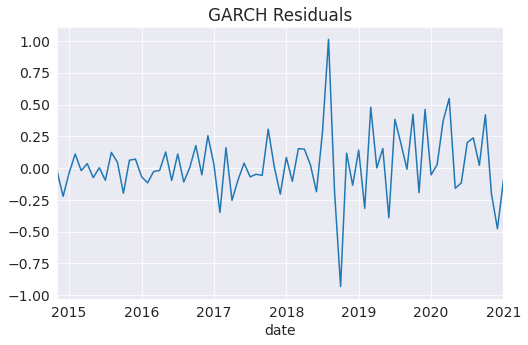

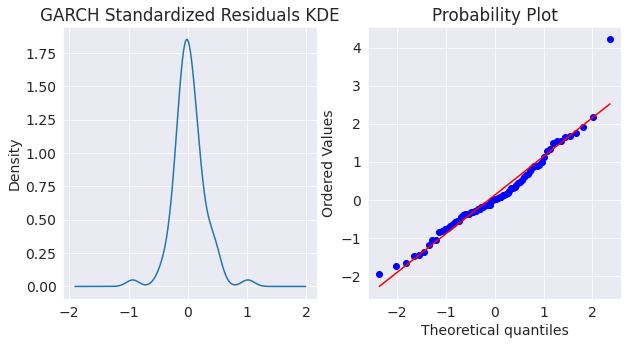

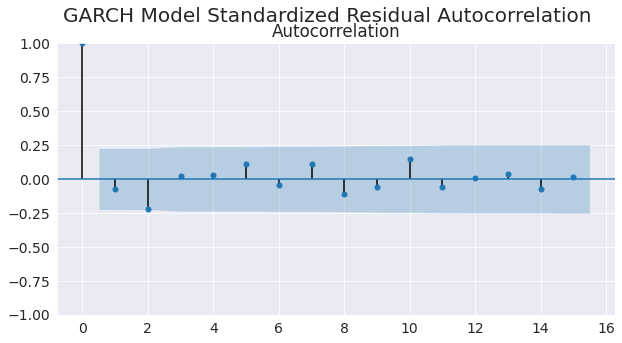

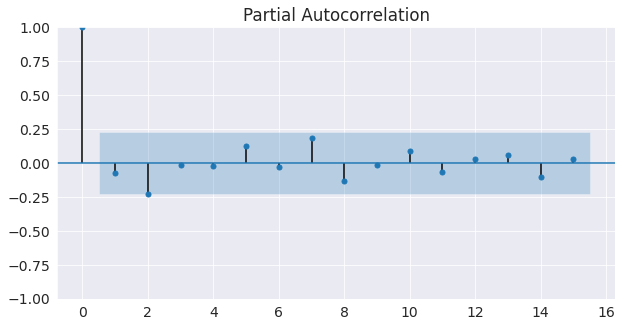

Shapiro-Wilks p-value: 0.01047654077410698


In [ ]:
#Diagnosis plots

resid = res.resid
st_resid = np.divide(resid, res.conditional_volatility)

ts_plot(resid, st_resid)
#arch_test = het_arch(resid, maxlag=12)
shapiro_test = shapiro(st_resid)
#print(f'Lagrange mulitplier p-value: {arch_test[1]}')
#print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

In [ ]:
# MODEL 2.2: RER with BITCOIN price

# We compute the ARIMA(1,1,2) GARCH(1,1) model

Y=df_monthly.loc['2014-11-01':'2021-01-01'].RER_d #dependent variable
X=df_monthly.loc['2014-11-01':'2021-01-01'][["DY_d", "RIR1_d", "OP_d", "BITCOIN_d"]] #exogenous variables

# Mean Model
model = ARIMA(Y, X, order=(1,0,2))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# residuals
residuals = DataFrame(model_fit.resid)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:538: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:538: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:538: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  RER_d   No. Observations:                   75
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 -12.042
Date:                Sat, 26 Jun 2021   AIC                             42.084
Time:                        14:09:41   BIC                             62.941
Sample:                    11-01-2014   HQIC                            50.412
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1512      0.071      2.136      0.033       0.012       0.290
DY_d          -1.7275      0.776     -2.226      0.026      -3.249      -0.206
RIR1_d         0.1153      0.041      2.790      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
print(model_fit.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &      RER\_d      & \textbf{  No. Observations:  } &     75      \\
\textbf{Model:}                  &  ARIMA(1, 0, 2)  & \textbf{  Log Likelihood     } &  -12.042    \\
\textbf{Date:}                   & Sat, 26 Jun 2021 & \textbf{  AIC                } &   42.084    \\
\textbf{Time:}                   &     14:09:41     & \textbf{  BIC                } &   62.941    \\
\textbf{Sample:}                 &    11-01-2014    & \textbf{  HQIC               } &   50.412    \\
\textbf{}                        &   - 01-01-2021   & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                    & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}      &       0.1512  &        0.071     &     2.136  &         0.033        &        0.012    &        0.290     \\
\textbf{DY\_d}      &

In [ ]:
#Conditional volatility model

am = arch_model(residuals, vol='GARCH')
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3.394453803869217
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2.6769944618743837
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2.4494410739476797
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2.0867676084695934
Iteration:      5,   Func. Count:     38,   Neg. LLF: 2.0451531493247903
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1.8076621305682803
Iteration:      7,   Func. Count:     52,   Neg. LLF: 1.4837156516723473
Iteration:      8,   Func. Count:     58,   Neg. LLF: 0.998533570913147
Iteration:      9,   Func. Count:     64,   Neg. LLF: 0.9871997764601269
Iteration:     10,   Func. Count:     71,   Neg. LLF: 0.9851141462239618
Iteration:     11,   Func. Count:     77,   Neg. LLF: 0.9832501710656059
Iteration:     12,   Func. Count:     83,   Neg. LLF: 0.9830822566038195
Iteration:     13,   Func. Count:     89,   Neg. LLF: 0.9830699413964059
Optimization terminated successfully.    (Exit mode 0

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &         0          & \textbf{  R-squared:         } &     0.000   \\
\textbf{Mean Model:}    &   Constant Mean    & \textbf{  Adj. R-squared:    } &     0.000   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &  -0.983070  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &    9.96614  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &    19.2361  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     75      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     74      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
            & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{mu} &      -0.0460  &    2.211e-02     &    -2.080  &      3.755e-02       &  [-8.932e-02,-2.649e-03]    \\

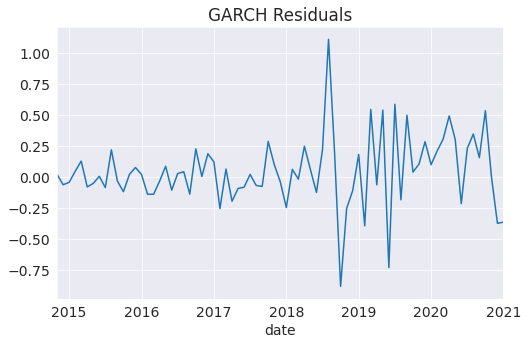

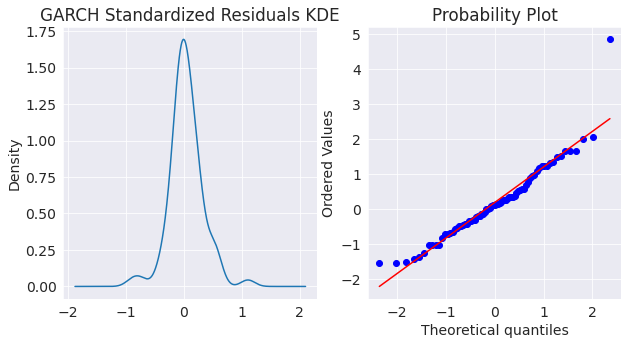

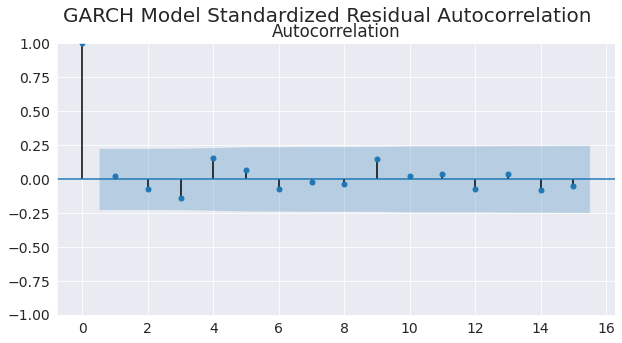

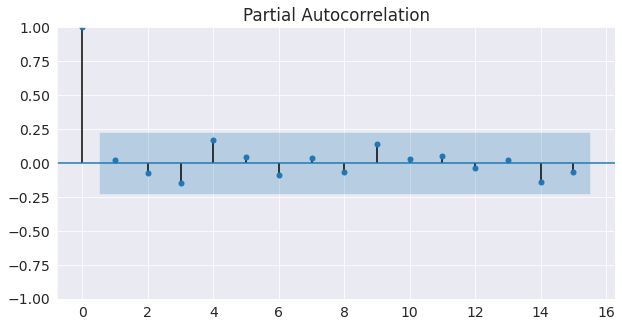

Shapiro-Wilks p-value: 0.00036048275069333613


In [ ]:
#Diagnosis plots

resid = res.resid
st_resid = np.divide(resid, res.conditional_volatility)

ts_plot(resid, st_resid)
#arch_test = het_arch(resid, maxlag=12)
shapiro_test = shapiro(st_resid)
#print(f'Lagrange mulitplier p-value: {arch_test[1]}')
#print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

In [ ]:
# MODEL 2.3: RER with BITCOIN GARCH volatility

# We compute the ARIMA(1,1,2) GARCH(1,1) model

Y=df_monthly.loc['2014-12-01':'2021-01-01'].RER_d #dependent variable
X=df_monthly.loc['2014-12-01':'2021-01-01'][["DY_d", "RIR1_d", "OP_d", "BITCOIN_var"]] #exogenous variables

# Mean Model
model = ARIMA(Y, X, order=(1,0,2))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# residuals
residuals = DataFrame(model_fit.resid)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:538: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:538: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:538: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  RER_d   No. Observations:                   74
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 -12.290
Date:                Sat, 26 Jun 2021   AIC                             42.580
Time:                        14:09:44   BIC                             63.316
Sample:                    12-01-2014   HQIC                            50.852
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1455      0.124      1.176      0.240      -0.097       0.388
DY_d           -1.6450      0.694     -2.371      0.018      -3.005      -0.285
RIR1_d          0.1108      0.045      2.462    

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
print(model_fit.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &      RER\_d      & \textbf{  No. Observations:  } &     74      \\
\textbf{Model:}                  &  ARIMA(1, 0, 2)  & \textbf{  Log Likelihood     } &  -12.290    \\
\textbf{Date:}                   & Sat, 26 Jun 2021 & \textbf{  AIC                } &   42.580    \\
\textbf{Time:}                   &     14:09:44     & \textbf{  BIC                } &   63.316    \\
\textbf{Sample:}                 &    12-01-2014    & \textbf{  HQIC               } &   50.852    \\
\textbf{}                        &   - 01-01-2021   & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                      & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}        &       0.1455  &        0.124     &     1.176  &         0.240        &       -0.097    &        0.388     \\
\textbf{DY\_d}   

In [ ]:
#Conditional volatility model

am = arch_model(residuals, vol='GARCH')
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3.836895763113251
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2.6150614637679244
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1.6875174011818035
Iteration:      4,   Func. Count:     31,   Neg. LLF: 0.8166582917783964
Iteration:      5,   Func. Count:     38,   Neg. LLF: 0.12184865224146474
Iteration:      6,   Func. Count:     45,   Neg. LLF: -0.27129625953261977
Iteration:      7,   Func. Count:     51,   Neg. LLF: -0.4469135146624363
Iteration:      8,   Func. Count:     57,   Neg. LLF: -0.7070164781702603
Iteration:      9,   Func. Count:     64,   Neg. LLF: -0.8921523241872443
Iteration:     10,   Func. Count:     70,   Neg. LLF: -0.9802663863323795
Iteration:     11,   Func. Count:     76,   Neg. LLF: -1.0011112028134055
Iteration:     12,   Func. Count:     82,   Neg. LLF: -1.0049383858070469
Iteration:     13,   Func. Count:     88,   Neg. LLF: -1.0051845960119348
Iteration:     14,   Func. Count:     94, 

####**V1 models**

In [ ]:
# MODEL 3.1: V1 without BITCOIN price

Y=df_quarterly.loc['2015-04-01':'2020-10-01'].V1_d #dependent variable
X=df_quarterly.loc['2015-04-01':'2020-10-01'][["GDP_d", "IR1_d"]] #exogenous variables

# Mean Model
model = ARIMA(Y, X, order=(1,0,2))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# residuals
residuals = DataFrame(model_fit.resid)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:594: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:594: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:594: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                   V1_d   No. Observations:                   20
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 -95.175
Date:                Sat, 26 Jun 2021   AIC                            204.349
Time:                        14:09:44   BIC                            211.320
Sample:                             0   HQIC                           205.710
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.8327     16.632     -1.253      0.210     -53.430      11.765
GDP_d          0.0015      0.001      2.238      0.025       0.000       0.003
IR1_d          4.0047      4.043      0.991      0.3

In [ ]:
print(model_fit.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &      V1\_d       & \textbf{  No. Observations:  } &     20      \\
\textbf{Model:}                  &  ARIMA(1, 0, 2)  & \textbf{  Log Likelihood     } &  -95.175    \\
\textbf{Date:}                   & Sat, 26 Jun 2021 & \textbf{  AIC                } &  204.349    \\
\textbf{Time:}                   &     14:09:44     & \textbf{  BIC                } &  211.320    \\
\textbf{Sample:}                 &        0         & \textbf{  HQIC               } &  205.710    \\
\textbf{}                        &       - 20       & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}  &     -20.8327  &       16.632     &    -1.253  &         0.210        &      -53.430    &       11.765     \\
\textbf{GDP\_d} &       0.001

In [ ]:
#Conditional volatility model

am = arch_model(residuals, vol='GARCH')
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 93.90623194274109
Iteration:      2,   Func. Count:     13,   Neg. LLF: 93.79814753244145
Iteration:      3,   Func. Count:     19,   Neg. LLF: 93.77085353907898
Iteration:      4,   Func. Count:     25,   Neg. LLF: 93.77038066074185
Iteration:      5,   Func. Count:     31,   Neg. LLF: 93.76839758308587
Iteration:      6,   Func. Count:     37,   Neg. LLF: 93.76688857013995
Iteration:      7,   Func. Count:     43,   Neg. LLF: 93.76687552438506
Iteration:      8,   Func. Count:     49,   Neg. LLF: 93.76687399173863
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 93.76687399170149
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:   

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &         0          & \textbf{  R-squared:         } &     0.000   \\
\textbf{Mean Model:}    &   Constant Mean    & \textbf{  Adj. R-squared:    } &     0.000   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &   -93.7669  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &    195.534  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &    199.517  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     20      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     19      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
            & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{mu} &       2.4141  &       18.518     &     0.130  &          0.896       &     [-33.880, 38.709]       \\

In [ ]:
# MODEL 3.2: V1 with BITCOIN price

Y=df_quarterly.loc['2015-04-01':'2020-10-01'].V1_d #dependent variable
X=df_quarterly.loc['2015-04-01':'2020-10-01'][["GDP_d", "IR1_d", "BITCOIN_d"]] #exogenous variables

# Mean Model
model = ARIMA(Y, X, order=(1,0,2))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# residuals
residuals = DataFrame(model_fit.resid)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:594: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:594: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:594: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                   V1_d   No. Observations:                   20
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 -93.424
Date:                Sat, 26 Jun 2021   AIC                            202.848
Time:                        14:09:45   BIC                            210.814
Sample:                             0   HQIC                           204.403
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.4112     16.508     -1.176      0.240     -51.765      12.943
GDP_d          0.0014      0.001      2.395      0.017       0.000       0.003
IR1_d          4.7626      4.140      1.150      0.2

In [ ]:
print(model_fit.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &      V1\_d       & \textbf{  No. Observations:  } &     20      \\
\textbf{Model:}                  &  ARIMA(1, 0, 2)  & \textbf{  Log Likelihood     } &  -93.424    \\
\textbf{Date:}                   & Sat, 26 Jun 2021 & \textbf{  AIC                } &  202.848    \\
\textbf{Time:}                   &     14:09:45     & \textbf{  BIC                } &  210.814    \\
\textbf{Sample:}                 &        0         & \textbf{  HQIC               } &  204.403    \\
\textbf{}                        &       - 20       & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                    & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}      &     -19.4112  &       16.508     &    -1.176  &         0.240        &      -51.765    &       12.943     \\
\textbf{GDP\_d}     &

In [ ]:
#Conditional volatility model

am = arch_model(residuals, vol='GARCH')
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 92.03335795765909
Iteration:      2,   Func. Count:     13,   Neg. LLF: 92.00817006437885
Iteration:      3,   Func. Count:     19,   Neg. LLF: 91.96021132396385
Iteration:      4,   Func. Count:     25,   Neg. LLF: 91.96020248385416
Iteration:      5,   Func. Count:     31,   Neg. LLF: 91.96018758212523
Iteration:      6,   Func. Count:     37,   Neg. LLF: 91.96016083153991
Iteration:      7,   Func. Count:     43,   Neg. LLF: 91.96013119796832
Iteration:      8,   Func. Count:     49,   Neg. LLF: 91.96011595587426
Iteration:      9,   Func. Count:     55,   Neg. LLF: 91.96011316408733
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 91.96011316402428
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      0   R-squared:               

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &         0          & \textbf{  R-squared:         } &     0.000   \\
\textbf{Mean Model:}    &   Constant Mean    & \textbf{  Adj. R-squared:    } &     0.000   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &   -91.9601  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &    191.920  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &    195.903  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     20      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     19      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
            & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{mu} &       5.0241  &        8.821     &     0.570  &          0.569       &     [-12.265, 22.313]       \\

In [ ]:
# MODEL 3.3: V1 with BITCOIN GARCH volatility

Y=df_quarterly.loc['2015-04-01':'2020-01-01'].V1_d #dependent variable
X=df_quarterly.loc['2015-04-01':'2020-01-01'][["GDP_d", "IR1_d", "BITCOIN_var"]] #exogenous variables

# Mean Model
model = ARIMA(Y, X, order=(1,0,2))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# residuals
residuals = DataFrame(model_fit.resid)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:594: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:594: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:594: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                   V1_d   No. Observations:                   17
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 -76.644
Date:                Sat, 26 Jun 2021   AIC                            169.287
Time:                        14:09:45   BIC                            175.953
Sample:                             0   HQIC                           169.950
                                 - 17                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.1808     91.276      0.407      0.684    -141.718     216.079
GDP_d           0.0013      0.001      1.168      0.243      -0.001       0.003
IR1_d           2.3913      3.736      0.640    

In [ ]:
print(model_fit.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &      V1\_d       & \textbf{  No. Observations:  } &     17      \\
\textbf{Model:}                  &  ARIMA(1, 0, 2)  & \textbf{  Log Likelihood     } &  -76.644    \\
\textbf{Date:}                   & Sat, 26 Jun 2021 & \textbf{  AIC                } &  169.287    \\
\textbf{Time:}                   &     14:09:45     & \textbf{  BIC                } &  175.953    \\
\textbf{Sample:}                 &        0         & \textbf{  HQIC               } &  169.950    \\
\textbf{}                        &       - 17       & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                      & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const}        &      37.1808  &       91.276     &     0.407  &         0.684        &     -141.718    &      216.079     \\
\textbf{GDP\_d}  

In [ ]:
#Conditional volatility model

am = arch_model(residuals, vol='GARCH')
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 75.87583117069511
Iteration:      2,   Func. Count:     14,   Neg. LLF: 75.86493524278231
Iteration:      3,   Func. Count:     20,   Neg. LLF: 75.8222452854256
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 75.82224528533963
            Iterations: 3
            Function evaluations: 20
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      0   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -75.8222
Distribution:                  Normal   AIC:                           159.644
Method:            Maximum Likelihood   BIC:                           162.977
                                        No. Observations:                   17
Date:                Sat

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &         0          & \textbf{  R-squared:         } &     0.000   \\
\textbf{Mean Model:}    &   Constant Mean    & \textbf{  Adj. R-squared:    } &     0.000   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &   -75.8222  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &    159.644  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &    162.977  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     17      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     16      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
            & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{mu} &      -1.7478  &        5.291     &    -0.330  &          0.741       &     [-12.117,  8.622]       \\

####**V2 models**

In [ ]:
# MODEL 4.1: V2 without BITCOIN price

Y=df_quarterly.loc['2015-04-01':'2020-10-01'].V2_d #dependent variable
X=df_quarterly.loc['2015-04-01':'2020-10-01'][["GDP_d", "IR1_d"]] #exogenous variables

ar = ARX(Y, X, lags=[1]) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                   V2_d   R-squared:                       0.742
Mean Model:                      AR-X   Adj. R-squared:                  0.690
Vol Model:                      GARCH   Log-Likelihood:               -56.5725
Distribution:                  Normal   AIC:                           127.145
Method:            Maximum Likelihood   BIC:                           133.756
                                        No. Observations:                   19
Date:                Sat, Jun 26 2021   Df Residuals:                       15
Time:                        14:09:45   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const         -3.3496      1.265     -2.648  8.100e-03    

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       V2\_d        & \textbf{  R-squared:         } &     0.742   \\
\textbf{Mean Model:}    &        AR-X        & \textbf{  Adj. R-squared:    } &     0.690   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &   -56.5725  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &    127.145  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &    133.756  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     19      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     15      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                  & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}    &      -3.3496  &        1.265     &    -2.648  &      8.100e-03       &     [ -5.829, -0.8

In [ ]:
# MODEL 4.2: V2 with BITCOIN price

Y=df_quarterly.loc['2015-04-01':'2020-10-01'].V2_d #dependent variable
X=df_quarterly.loc['2015-04-01':'2020-10-01'][["GDP_d", "IR1_d", "BITCOIN_d"]] #exogenous variables

ar = ARX(Y, X, lags=[1]) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                   V2_d   R-squared:                       0.756
Mean Model:                      AR-X   Adj. R-squared:                  0.687
Vol Model:                      GARCH   Log-Likelihood:               -56.0415
Distribution:                  Normal   AIC:                           128.083
Method:            Maximum Likelihood   BIC:                           135.639
                                        No. Observations:                   19
Date:                Sat, Jun 26 2021   Df Residuals:                       14
Time:                        14:09:45   Df Model:                            5
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const          -2.9522      1.559     -1.894  5.823e

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       V2\_d        & \textbf{  R-squared:         } &     0.756   \\
\textbf{Mean Model:}    &        AR-X        & \textbf{  Adj. R-squared:    } &     0.687   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &   -56.0415  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &    128.083  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &    135.639  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     19      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     14      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                    & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}      &      -2.9522  &        1.559     &    -1.894  &      5.823e-02       &     [ -6.007, 

In [ ]:
# MODEL 4.3: V2 with BITCOIN GARCH volatility

Y=df_quarterly.loc['2015-04-01':'2020-01-01'].V2_d #dependent variable
X=df_quarterly.loc['2015-04-01':'2020-01-01'][["GDP_d", "IR1_d", "BITCOIN_var"]] #exogenous variables

ar = ARX(Y, X, lags=[1]) # Mean model
ar.volatility = GARCH(p=1) # Volatility model
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                   V2_d   R-squared:                       0.411
Mean Model:                      AR-X   Adj. R-squared:                  0.197
Vol Model:                      GARCH   Log-Likelihood:               -44.2791
Distribution:                  Normal   AIC:                           104.558
Method:            Maximum Likelihood   BIC:                           110.739
                                        No. Observations:                   16
Date:                Sat, Jun 26 2021   Df Residuals:                       11
Time:                        14:09:46   Df Model:                            5
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const            3.4458      5.243      0.657    

In [ ]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:} &       V2\_d        & \textbf{  R-squared:         } &     0.411   \\
\textbf{Mean Model:}    &        AR-X        & \textbf{  Adj. R-squared:    } &     0.197   \\
\textbf{Vol Model:}     &       GARCH        & \textbf{  Log-Likelihood:    } &   -44.2791  \\
\textbf{Distribution:}  &       Normal       & \textbf{  AIC:               } &    104.558  \\
\textbf{Method:}        & Maximum Likelihood & \textbf{  BIC:               } &    110.739  \\
\textbf{}               &                    & \textbf{  No. Observations:  } &     16      \\
\textbf{Date:}          &  Sat, Jun 26 2021  & \textbf{  Df Residuals:      } &     11      \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                      & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$> |$t$|$} & \textbf{95.0\% Conf. Int.}  \\
\midrule
\textbf{Const}        &       3.4458  &        5.243     &     0.657  &          0.511       &     [ -6.8